# カーネル行列のrank推移

GP-KANの学習中にカーネル行列のrankがどのように変化したかを時系列で可視化する。

## 1.問題設定

真の関数: フーリエ級数
$$f(t) = \frac{4}{\pi} \sum_{n=1}^{N} \frac{1}{n} \sin(nt), \quad n = 1, 3, 5, \ldots, \quad t \in [0, 1]$$
※$N=15$

データ: 
- 合計1,000件: 学習700件/検証150件/評価150件
- tは$(-1,1)$から一様ランダムサンプリング

モデル:
- 2層のGPKAN: 入力1次元/中間層2次元/出力1次元
    - それぞれのGPを(<1層目のindex>,<2層目のindex>)形式で表すことにすると、GPKANは$(0,0),(0,1),(1,0),(1,1)$の4つのGPで構成


## 2.メイン処理
本ノートブックのメイン処理を実行する。実行順は以下の通り：

2-1.データセット作成

2-2.GPKANの学習

2-3.精度評価

2-4.学習中のカーネル行列ランク可視化

### 2-1.データセット作成

In [ ]:
# 初期設定: 必要なライブラリをインポートし、パスを設定
import os
import sys

sys.path.append("../")
import torch.utils.data
from lib import model as gplib
from lib import runner
from torch.utils.data import DataLoader

Train samples: 700
Validation samples: 150
Test samples: 150


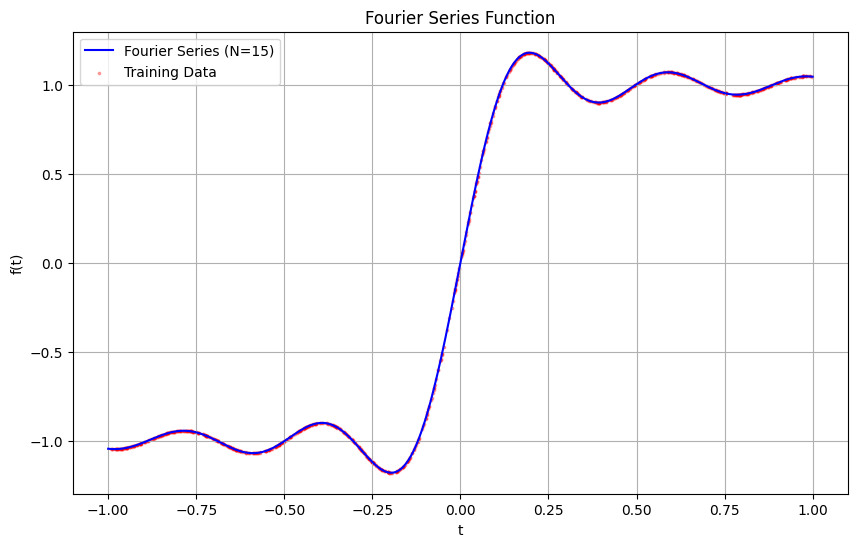

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset

# Generate synthetic data with Fourier series function
np.random.seed(42)  # for reproducibility
num_samples = 1000

# Generate random input points t from [-1, 1]
t = np.random.uniform(-1, 1, num_samples)


# Compute target values: f(t) = (4/π) * Σ(1/n * sin(nt)) for odd n up to N=15
def fourier_series(t, N=15):
    result = np.zeros_like(t)
    for n in range(1, N + 1, 2):  # odd numbers only: 1, 3, 5, 7, 9, 11, 13, 15
        result += (1 / n) * np.sin(n * t)
    return (4 / np.pi) * result


targets = fourier_series(t, N=15)

# Reshape inputs (t is 1D, but we need it as 2D for compatibility)
inputs = t.reshape(-1, 1)

# Convert to PyTorch tensors
X_tensor = torch.FloatTensor(inputs)
y_tensor = torch.FloatTensor(targets).reshape(-1, 1)

# Split data into train, validation, and test sets
train_size = int(0.7 * num_samples)
val_size = int(0.15 * num_samples)
test_size = num_samples - train_size - val_size

X_train = X_tensor[:train_size]
y_train = y_tensor[:train_size]

X_val = X_tensor[train_size : train_size + val_size]
y_val = y_tensor[train_size : train_size + val_size]

X_test = X_tensor[train_size + val_size :]
y_test = y_tensor[train_size + val_size :]

# データを昇順にソート（X_testとy_testを対応を保ちながら）
sorted_indices = torch.argsort(X_test.squeeze())
X_test = X_test[sorted_indices]
y_test = y_test[sorted_indices]

# Create datasets
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

# Create dataloaders
batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

print(f"Train samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")

# Plot the Fourier series function
t_plot = np.linspace(-1, 1, 1000)
y_plot = fourier_series(t_plot, N=15)
plt.figure(figsize=(10, 6))
plt.plot(t_plot, y_plot, "b-", label="Fourier Series (N=15)")
plt.scatter(t, targets, alpha=0.3, s=3, c="red", label="Training Data")
plt.xlabel("t")
plt.ylabel("f(t)")
plt.title("Fourier Series Function")
plt.legend()
plt.grid(True)
plt.show()

### 2-2.モデル学習

In [ ]:
num_gp_pts = 10  # Number of Gaussian Process points
model = gplib.GP_Model(
    [
        gplib.LayerFused(1, 2, num_gp_pts),
        gplib.LayerFused(2, 1, num_gp_pts),
    ],
    saveload_path="model121.pt",
)
np.random.seed(42)  # for reproducibility

In [ ]:
# カーネル行列のランクを計算
def compute_kernel_rank(model, depth=0):
    layer = model.layers[depth]
    inducing_points = layer.z.detach()  # Shape: [1, 2, X]
    lengthscale = layer.l.detach()  # Shape: [1, 2]
    variance = layer.s.detach()  # Shape: [1, 2]

    # Initialize lists to store results for all GPs
    all_ranks = []
    all_condition_numbers = []
    all_eigenvals = []

    # Iterate over each GP in the 1x3 configuration
    for i in range(inducing_points.shape[0]):  # 1
        for j in range(inducing_points.shape[1]):  # 2
            # Get parameters for this specific GP
            z_ij = inducing_points[i, j, :]  # Shape: [X]
            l_ij = lengthscale[i, j]  # Scalar
            s_ij = variance[i, j]  # Scalar

            # Reshape inducing points for distance computation
            z_ij = z_ij.unsqueeze(1)  # Shape: [X, 1]

            # Compute kernel matrix for this GP
            pairwise_sq_dists = torch.cdist(z_ij, z_ij, p=2) ** 2
            K = s_ij * torch.exp(-pairwise_sq_dists / (2 * l_ij**2))

            # Compute rank and eigenvalues
            rank = torch.linalg.matrix_rank(K).item()
            eigenvals = torch.linalg.eigvals(K).real
            eigenvals = torch.clamp(eigenvals, min=1e-10)  # 負の固有値を1e-10に補完
            condition_number = eigenvals.max() / eigenvals.min()

            all_ranks.append(rank)
            all_condition_numbers.append(condition_number.item())
            all_eigenvals.append(eigenvals)

    return all_ranks, all_condition_numbers, all_eigenvals

In [ ]:
# 精度評価/可視化関数
def plot_result(model):
    # テストデータでの予測
    with torch.no_grad():
        # バッチごとに予測を行う
        test_predictions = []
        test_targets = []
        test_variances = []

        for X_batch, y_batch in test_dataloader:
            pred = model.predict(X_batch).mean
            var = model.predict(X_batch).var
            test_predictions.append(pred)
            test_variances.append(var)
            test_targets.append(y_batch)

        # 結果を結合
        test_predictions = torch.cat(test_predictions, dim=0)
        test_targets = torch.cat(test_targets, dim=0)
        test_variances = torch.cat(test_variances, dim=0)

    # MSE計算
    mse = torch.mean((test_predictions - test_targets) ** 2)
    rmse = torch.sqrt(mse)

    print(f"Test MSE: {mse.item():.6f}")
    print(f"Test RMSE: {rmse.item():.6f}")

    # 可視化用のデータ準備
    t_test = X_test.numpy().flatten()
    y_test_true = y_test.numpy().flatten()
    y_test_pred = test_predictions.numpy().flatten()

    # 真の関数の連続プロット用
    t_continuous = np.linspace(-1, 1, 500)
    y_continuous = fourier_series(t_continuous, N=15)

    # グラフ作成
    plt.figure(figsize=(12, 8))

    # 真の関数
    plt.plot(
        t_continuous,
        y_continuous,
        "b-",
        linewidth=2,
        label="True Function (Fourier Series)",
        alpha=0.8,
    )

    # テストデータの真値
    plt.scatter(
        t_test,
        y_test_true,
        c="red",
        s=30,
        alpha=0.6,
        label="Test Data (True)",
        marker="o",
    )

    # 予測値
    plt.scatter(
        t_test, y_test_pred, c="green", s=30, alpha=0.6, label="Predictions", marker="x"
    )

    # 予測の不確実性を帯で表示
    lower_bound = y_test_pred - 1.96 * np.sqrt(test_variances.numpy().flatten())
    upper_bound = y_test_pred + 1.96 * np.sqrt(test_variances.numpy().flatten())
    plt.fill_between(
        t_test,
        lower_bound,
        upper_bound,
        color="lightgreen",
        alpha=0.3,
        label="95% Prediction Interval",
    )

    plt.xlabel("t")
    plt.ylabel("f(t)")
    plt.title(f"GP-KAN Prediction vs True Function\nTest RMSE: {rmse.item():.6f}")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    # 残差プロット
    plt.figure(figsize=(10, 6))
    residuals = y_test_pred - y_test_true
    plt.scatter(t_test, residuals, c="purple", s=30, alpha=0.6)
    plt.axhline(y=0, color="red", linestyle="--", alpha=0.7)
    plt.xlabel("t")
    plt.ylabel("Residuals (Predicted - True)")
    plt.title("Residual Plot")
    plt.grid(True, alpha=0.3)
    plt.show()

    # 残差の統計情報
    print(f"\nResidual Statistics:")
    print(f"Mean: {np.mean(residuals):.6f}")
    print(f"Std: {np.std(residuals):.6f}")
    print(f"Min: {np.min(residuals):.6f}")
    print(f"Max: {np.max(residuals):.6f}")

    print("plot completed")
    return 0

epoch 0  , train negloglik: 146.62767,    val negloglik: 1.61670    accuracy: 0.9597 lr: [0.0001]
epoch 1  , train negloglik: 2.61192,    val negloglik: 1.55225    accuracy: 1.0704 lr: [9e-05]
epoch 2  , train negloglik: 1.86774,    val negloglik: 1.33361    accuracy: 0.9013 lr: [9e-05]
epoch 3  , train negloglik: 1.29581,    val negloglik: 1.25957    accuracy: 0.4826 lr: [9e-05]
epoch 4  , train negloglik: 1.25485,    val negloglik: 1.24884    accuracy: 0.4810 lr: [9e-05]
epoch 5  , train negloglik: 1.24431,    val negloglik: 1.19142    accuracy: 0.4507 lr: [9e-05]
epoch 6  , train negloglik: 1.20233,    val negloglik: 1.16914    accuracy: 0.4379 lr: [9e-05]
epoch 7  , train negloglik: 1.16900,    val negloglik: 1.12252    accuracy: 0.4531 lr: [9e-05]
epoch 8  , train negloglik: 1.13798,    val negloglik: 1.09615    accuracy: 0.4352 lr: [9e-05]
epoch 9  , train negloglik: 1.11303,    val negloglik: 1.38562    accuracy: 0.4122 lr: [9e-05]
Test MSE: 0.474432
Test RMSE: 0.688790


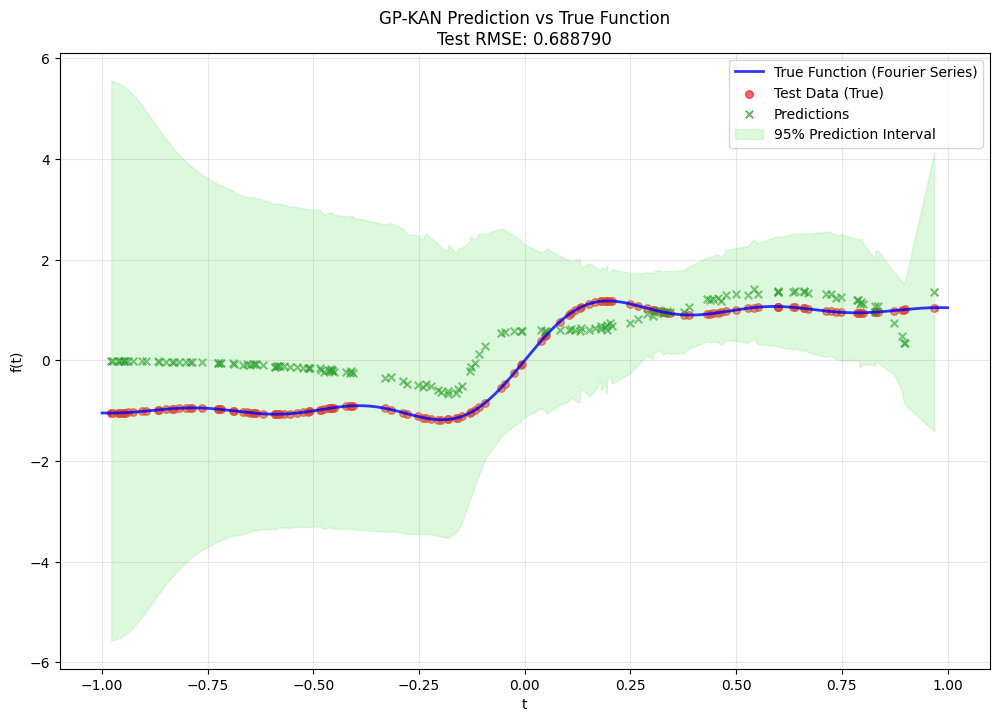

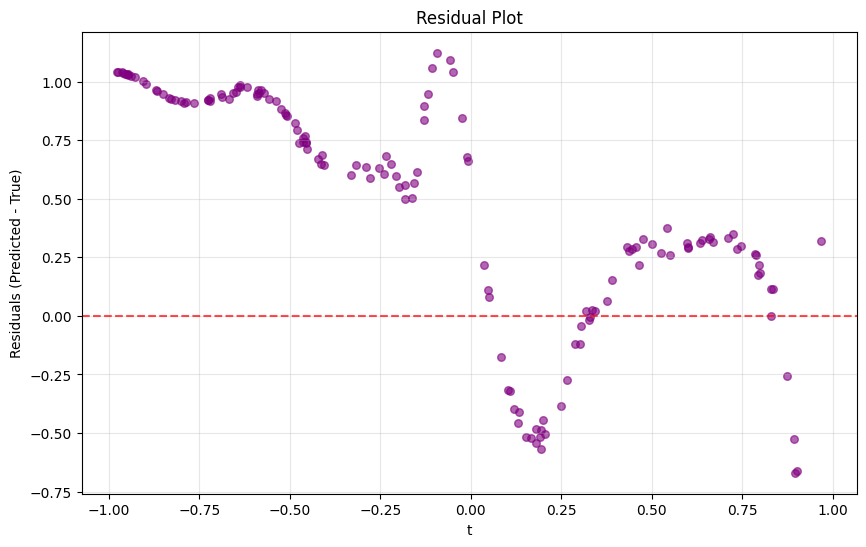


Residual Statistics:
Mean: 0.478783
Std: 0.495176
Min: -0.669421
Max: 1.123299
plot completed
epoch 0  , train negloglik: 1.08273,    val negloglik: 1.29695    accuracy: 0.3919 lr: [0.0001]
epoch 1  , train negloglik: 1.08481,    val negloglik: 1.13832    accuracy: 0.3740 lr: [9e-05]
epoch 2  , train negloglik: 1.04837,    val negloglik: 1.00536    accuracy: 0.4210 lr: [9e-05]
epoch 3  , train negloglik: 1.03058,    val negloglik: 0.98642    accuracy: 0.4094 lr: [9e-05]
epoch 4  , train negloglik: 1.09290,    val negloglik: 0.99436    accuracy: 0.4706 lr: [9e-05]
epoch 5  , train negloglik: 1.17758,    val negloglik: 1.06045    accuracy: 0.3378 lr: [9e-05]
epoch 6  , train negloglik: 1.11351,    val negloglik: 1.02735    accuracy: 0.3673 lr: [9e-05]
epoch 7  , train negloglik: 1.03489,    val negloglik: 0.97152    accuracy: 0.3857 lr: [9e-05]
epoch 8  , train negloglik: 1.07686,    val negloglik: 1.11107    accuracy: 0.4979 lr: [9e-05]
epoch 9  , train negloglik: 1.11864,    val neglo

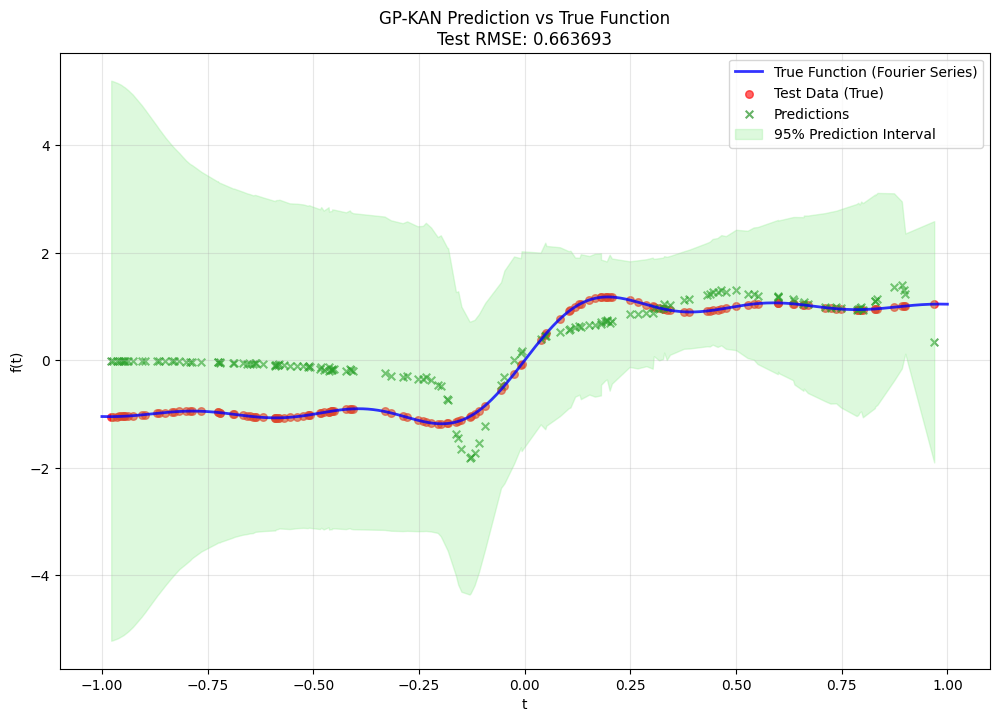

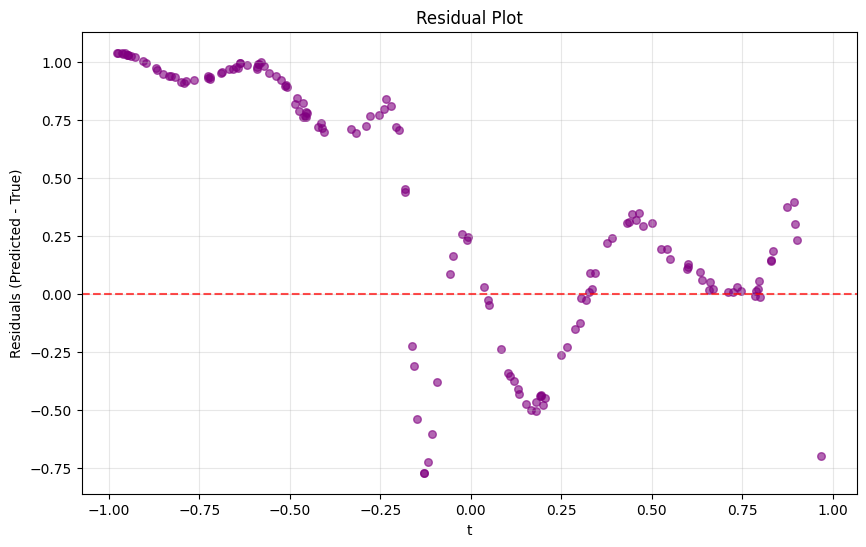


Residual Statistics:
Mean: 0.392280
Std: 0.535355
Min: -0.770986
Max: 1.040608
plot completed
epoch 0  , train negloglik: 1.07177,    val negloglik: 1.04291    accuracy: 0.4959 lr: [0.0001]
epoch 1  , train negloglik: 1.04809,    val negloglik: 1.00960    accuracy: 0.4848 lr: [9e-05]
epoch 2  , train negloglik: 1.02175,    val negloglik: 0.94949    accuracy: 0.4275 lr: [9e-05]
epoch 3  , train negloglik: 0.99540,    val negloglik: 0.96856    accuracy: 0.4620 lr: [9e-05]
epoch 4  , train negloglik: 0.98541,    val negloglik: 0.91757    accuracy: 0.4044 lr: [9e-05]
epoch 5  , train negloglik: 0.96146,    val negloglik: 0.89230    accuracy: 0.4194 lr: [9e-05]
epoch 6  , train negloglik: 0.95085,    val negloglik: 0.87317    accuracy: 0.4123 lr: [9e-05]
epoch 7  , train negloglik: 0.93046,    val negloglik: 0.83706    accuracy: 0.3757 lr: [9e-05]
epoch 8  , train negloglik: 0.91344,    val negloglik: 0.84804    accuracy: 0.3853 lr: [9e-05]
epoch 9  , train negloglik: 0.89227,    val neglo

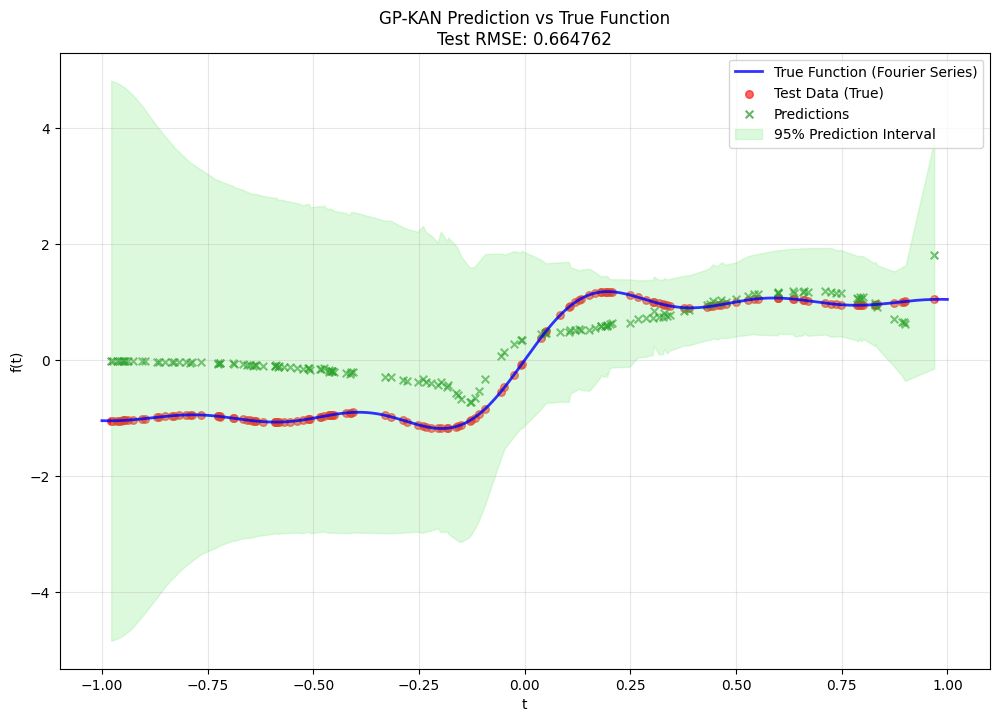

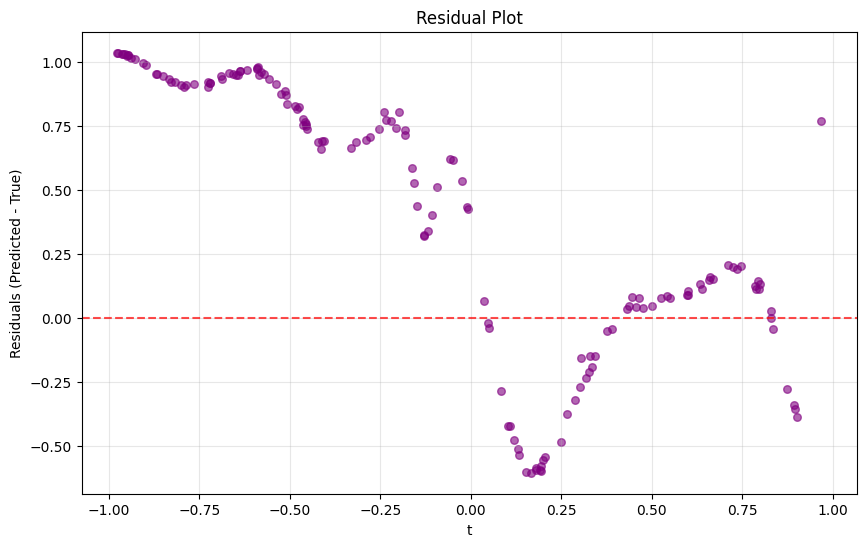


Residual Statistics:
Mean: 0.408848
Std: 0.524168
Min: -0.605545
Max: 1.035842
plot completed
epoch 0  , train negloglik: 0.87044,    val negloglik: 0.81948    accuracy: 0.3979 lr: [0.0001]
epoch 1  , train negloglik: 0.85263,    val negloglik: 0.79331    accuracy: 0.3891 lr: [9e-05]
epoch 2  , train negloglik: 0.84611,    val negloglik: 0.76558    accuracy: 0.3524 lr: [9e-05]
epoch 3  , train negloglik: 0.82694,    val negloglik: 0.85372    accuracy: 0.3822 lr: [9e-05]
epoch 4  , train negloglik: 0.80807,    val negloglik: 0.73540    accuracy: 0.3669 lr: [9e-05]
epoch 5  , train negloglik: 0.85848,    val negloglik: 0.74528    accuracy: 0.3817 lr: [9e-05]
epoch 6  , train negloglik: 0.81334,    val negloglik: 0.71472    accuracy: 0.3515 lr: [9e-05]
epoch 7  , train negloglik: 0.76390,    val negloglik: 0.69707    accuracy: 0.3521 lr: [9e-05]
epoch 8  , train negloglik: 0.78711,    val negloglik: 0.74647    accuracy: 0.3849 lr: [9e-05]
epoch 9  , train negloglik: 0.78227,    val neglo

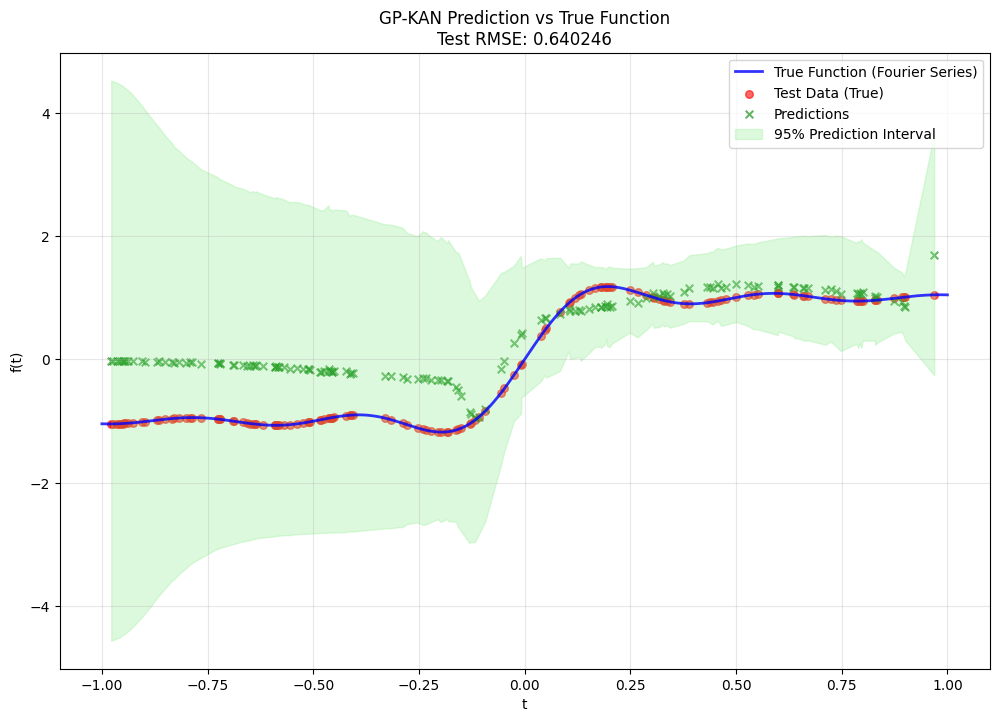

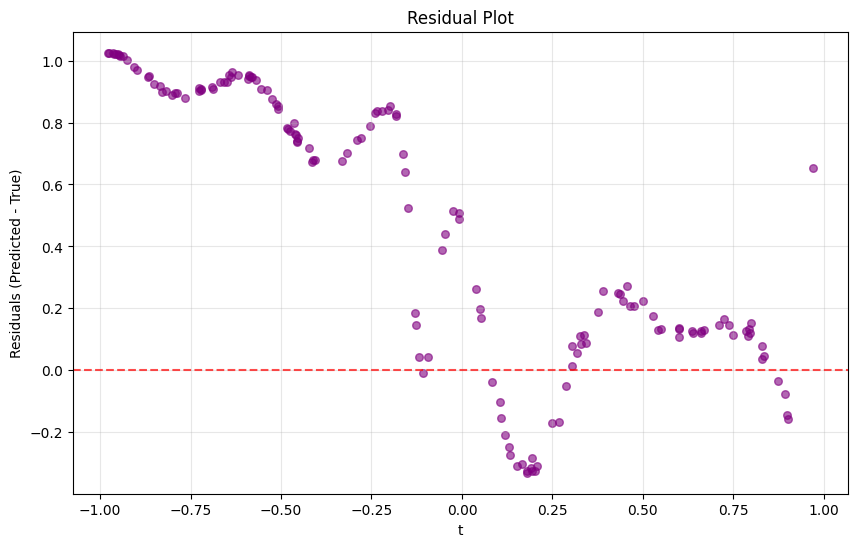


Residual Statistics:
Mean: 0.466866
Std: 0.438122
Min: -0.331071
Max: 1.025568
plot completed
epoch 0  , train negloglik: 0.75567,    val negloglik: 0.70664    accuracy: 0.3720 lr: [0.0001]
epoch 1  , train negloglik: 0.75807,    val negloglik: 0.63292    accuracy: 0.3489 lr: [9e-05]
epoch 2  , train negloglik: 0.75882,    val negloglik: 0.67300    accuracy: 0.3802 lr: [9e-05]
epoch 3  , train negloglik: 0.71001,    val negloglik: 0.82668    accuracy: 0.3549 lr: [9e-05]
epoch 4  , train negloglik: 0.68256,    val negloglik: 0.59535    accuracy: 0.3555 lr: [9e-05]
epoch 5  , train negloglik: 0.67913,    val negloglik: 0.62358    accuracy: 0.3680 lr: [9e-05]
epoch 6  , train negloglik: 0.65991,    val negloglik: 0.59280    accuracy: 0.3685 lr: [9e-05]
epoch 7  , train negloglik: 0.63814,    val negloglik: 0.57968    accuracy: 0.3727 lr: [9e-05]
epoch 8  , train negloglik: 0.63313,    val negloglik: 0.54748    accuracy: 0.3563 lr: [9e-05]
epoch 9  , train negloglik: 0.61564,    val neglo

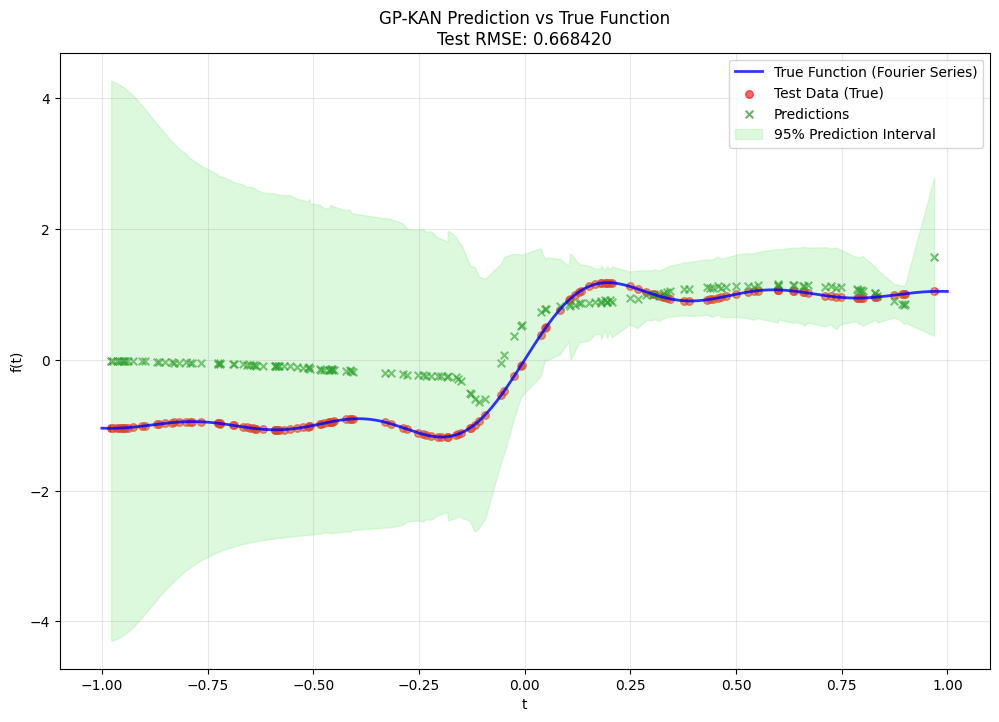

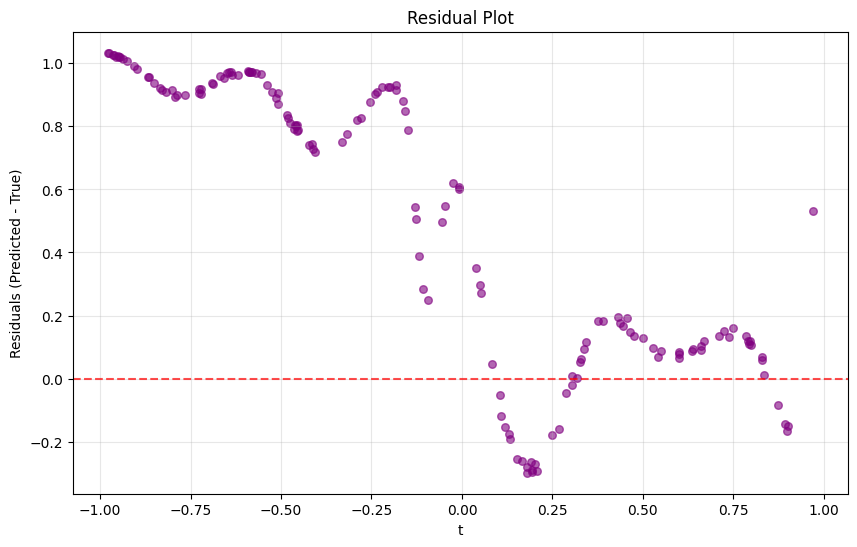


Residual Statistics:
Mean: 0.496480
Std: 0.447541
Min: -0.298606
Max: 1.033659
plot completed
epoch 0  , train negloglik: 0.61616,    val negloglik: 0.54276    accuracy: 0.3759 lr: [0.0001]
epoch 1  , train negloglik: 0.69286,    val negloglik: 0.53780    accuracy: 0.4064 lr: [9e-05]
epoch 2  , train negloglik: 0.59330,    val negloglik: 0.52276    accuracy: 0.3864 lr: [9e-05]
epoch 3  , train negloglik: 0.58046,    val negloglik: 0.50353    accuracy: 0.3914 lr: [9e-05]
epoch 4  , train negloglik: 0.56433,    val negloglik: 0.51857    accuracy: 0.4068 lr: [9e-05]
epoch 5  , train negloglik: 0.57061,    val negloglik: 0.51337    accuracy: 0.4018 lr: [9e-05]
epoch 6  , train negloglik: 0.55421,    val negloglik: 0.48575    accuracy: 0.3952 lr: [9e-05]
epoch 7  , train negloglik: 0.57190,    val negloglik: 0.46817    accuracy: 0.3845 lr: [9e-05]
epoch 8  , train negloglik: 0.54307,    val negloglik: 0.45427    accuracy: 0.3910 lr: [9e-05]
epoch 9  , train negloglik: 0.52811,    val neglo

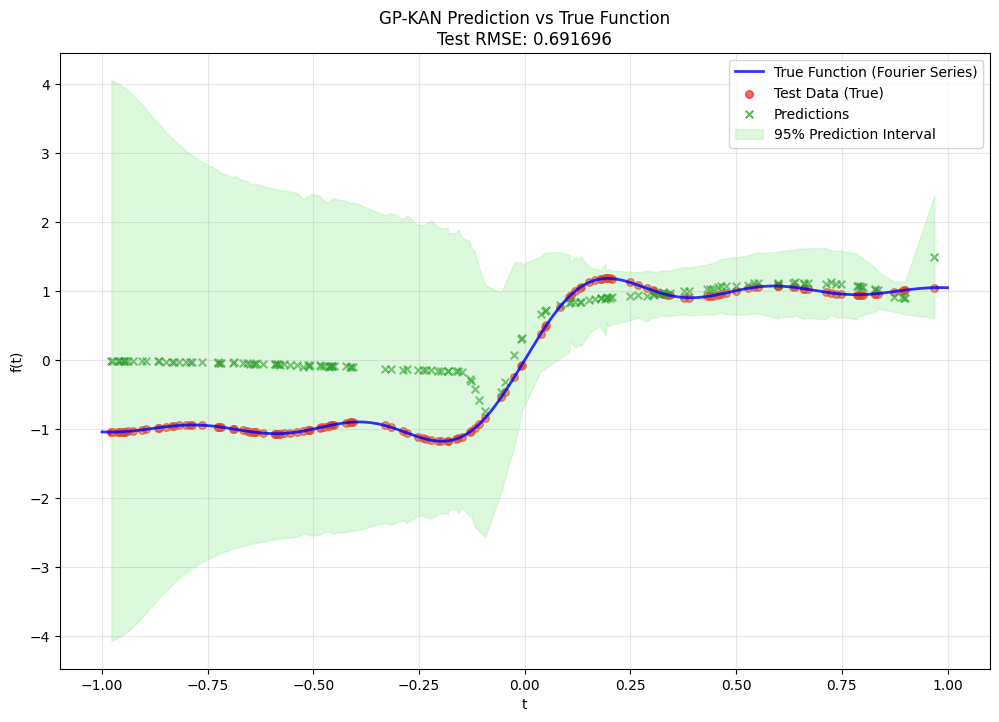

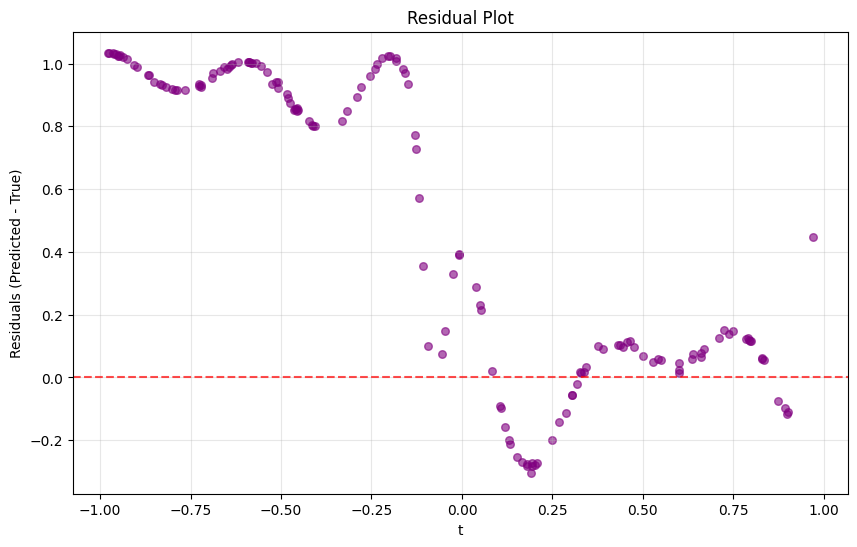


Residual Statistics:
Mean: 0.500389
Std: 0.477551
Min: -0.303739
Max: 1.034443
plot completed
epoch 0  , train negloglik: 0.52704,    val negloglik: 0.45390    accuracy: 0.3976 lr: [0.0001]
epoch 1  , train negloglik: 0.53104,    val negloglik: 0.44635    accuracy: 0.3868 lr: [9e-05]
epoch 2  , train negloglik: 0.51457,    val negloglik: 0.60134    accuracy: 0.3723 lr: [9e-05]
epoch 3  , train negloglik: 0.52196,    val negloglik: 0.45197    accuracy: 0.3875 lr: [9e-05]
epoch 4  , train negloglik: 0.49449,    val negloglik: 0.43517    accuracy: 0.3915 lr: [9e-05]
epoch 5  , train negloglik: 0.49485,    val negloglik: 0.44498    accuracy: 0.3839 lr: [9e-05]
epoch 6  , train negloglik: 0.48168,    val negloglik: 0.42477    accuracy: 0.3911 lr: [9e-05]
epoch 7  , train negloglik: 0.47411,    val negloglik: 0.40905    accuracy: 0.3889 lr: [9e-05]
epoch 8  , train negloglik: 0.45745,    val negloglik: 0.40116    accuracy: 0.3889 lr: [9e-05]
epoch 9  , train negloglik: 0.46736,    val neglo

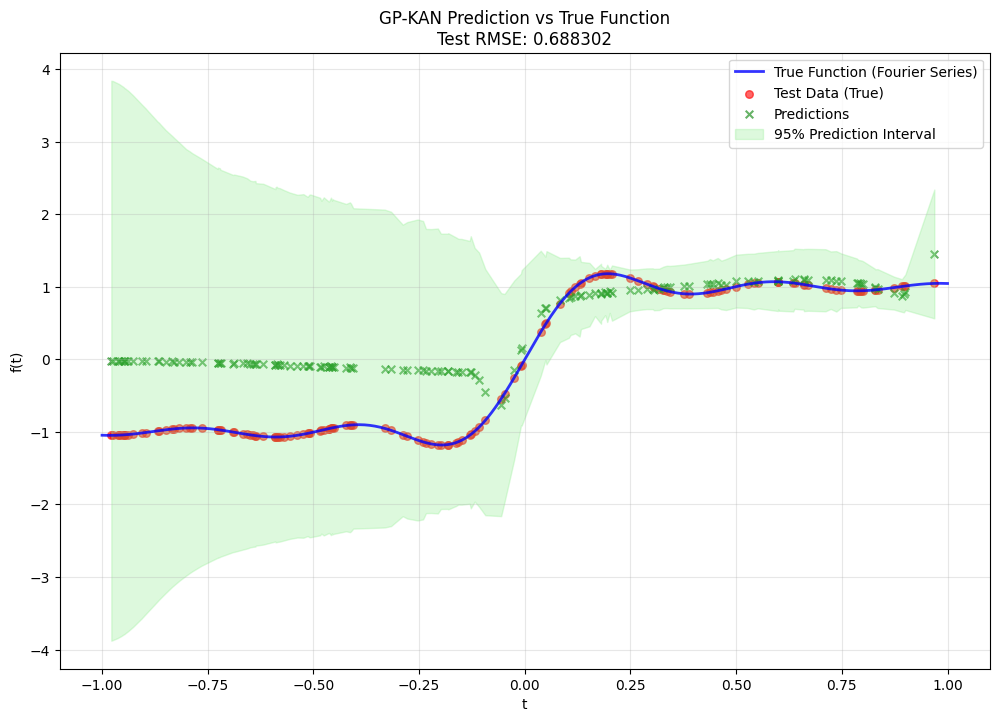

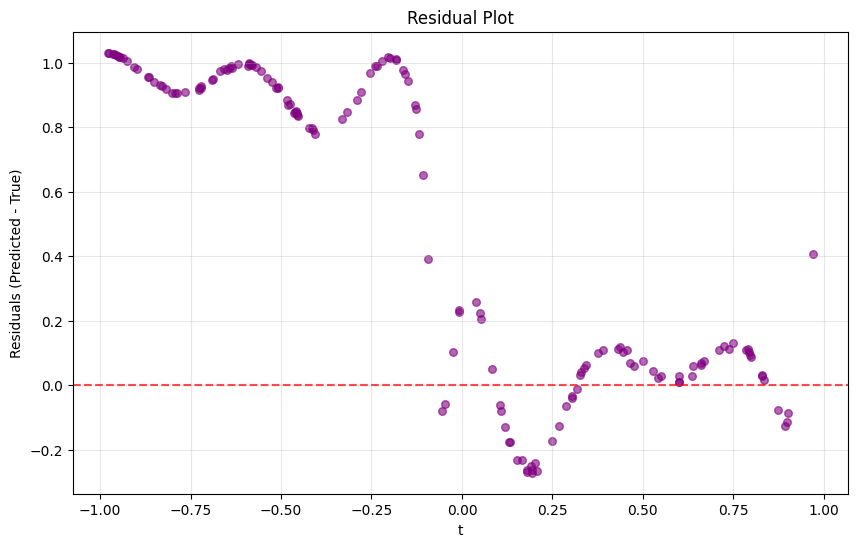


Residual Statistics:
Mean: 0.497294
Std: 0.475876
Min: -0.270930
Max: 1.030618
plot completed
epoch 0  , train negloglik: 0.45690,    val negloglik: 0.39330    accuracy: 0.3861 lr: [0.0001]
epoch 1  , train negloglik: 0.44660,    val negloglik: 0.37613    accuracy: 0.3807 lr: [9e-05]
epoch 2  , train negloglik: 0.43940,    val negloglik: 0.37502    accuracy: 0.3765 lr: [9e-05]
epoch 3  , train negloglik: 0.42849,    val negloglik: 0.36173    accuracy: 0.3719 lr: [9e-05]
epoch 4  , train negloglik: 0.42487,    val negloglik: 0.36213    accuracy: 0.3749 lr: [9e-05]
epoch 5  , train negloglik: 0.43040,    val negloglik: 0.36266    accuracy: 0.3722 lr: [9e-05]
epoch 6  , train negloglik: 0.40769,    val negloglik: 0.35598    accuracy: 0.3745 lr: [9e-05]
epoch 7  , train negloglik: 0.41473,    val negloglik: 0.35898    accuracy: 0.3696 lr: [9e-05]
epoch 8  , train negloglik: 0.39968,    val negloglik: 0.34822    accuracy: 0.3821 lr: [9e-05]
epoch 9  , train negloglik: 0.39620,    val neglo

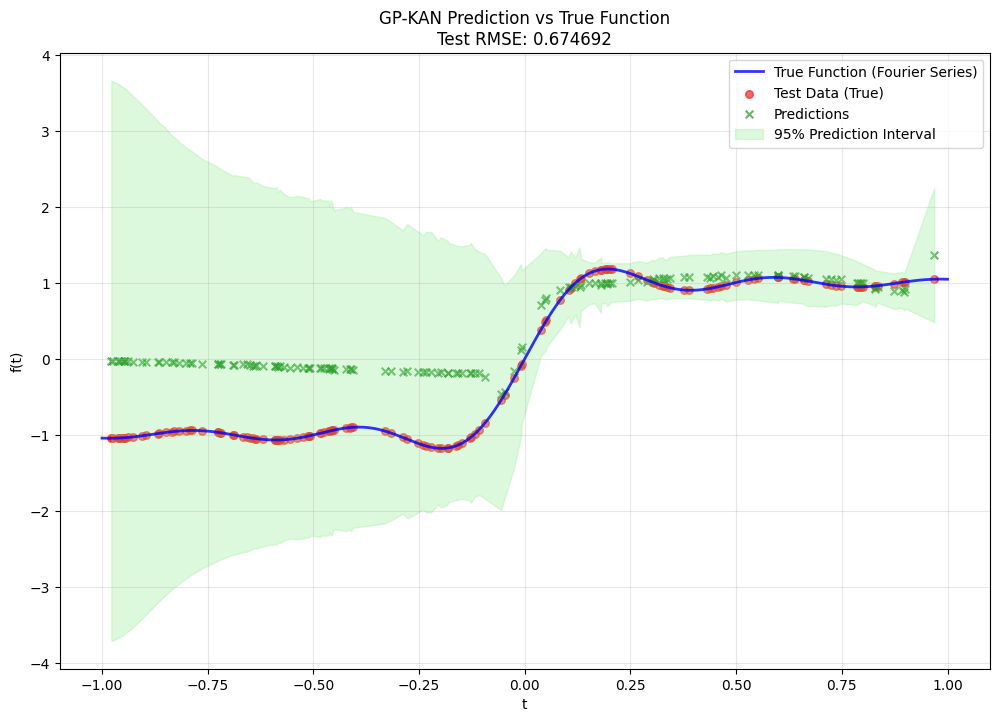

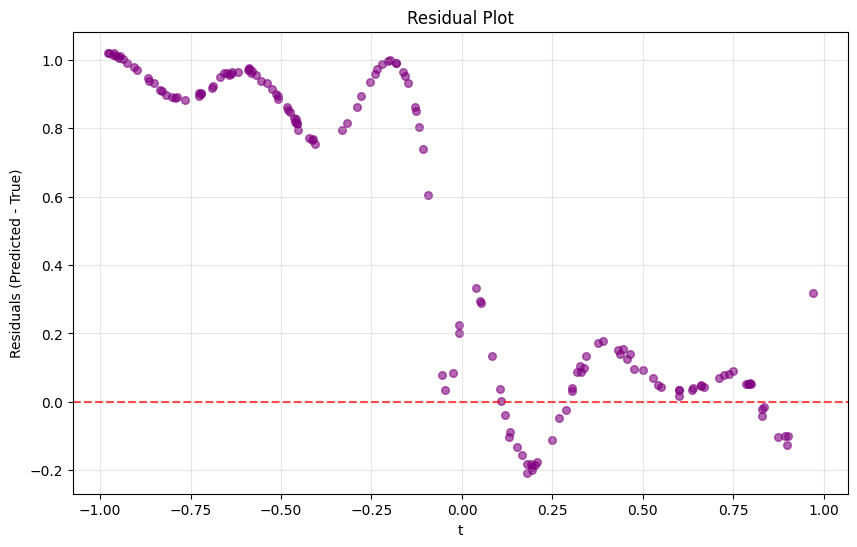


Residual Statistics:
Mean: 0.502508
Std: 0.450217
Min: -0.207222
Max: 1.020700
plot completed
epoch 0  , train negloglik: 0.38328,    val negloglik: 0.32118    accuracy: 0.3688 lr: [0.0001]
epoch 1  , train negloglik: 0.39141,    val negloglik: 0.33311    accuracy: 0.3825 lr: [9e-05]
epoch 2  , train negloglik: 0.39399,    val negloglik: 0.30555    accuracy: 0.3876 lr: [9e-05]
epoch 3  , train negloglik: 0.36664,    val negloglik: 0.31942    accuracy: 0.3757 lr: [9e-05]
epoch 4  , train negloglik: 0.36164,    val negloglik: 0.28593    accuracy: 0.3710 lr: [9e-05]
epoch 5  , train negloglik: 0.35793,    val negloglik: 0.32147    accuracy: 0.3714 lr: [9e-05]
epoch 6  , train negloglik: 0.35804,    val negloglik: 0.28774    accuracy: 0.3601 lr: [9e-05]
epoch 7  , train negloglik: 0.35340,    val negloglik: 0.27337    accuracy: 0.3692 lr: [9e-05]
epoch 8  , train negloglik: 0.33334,    val negloglik: 0.27671    accuracy: 0.3777 lr: [9e-05]
epoch 9  , train negloglik: 0.32540,    val neglo

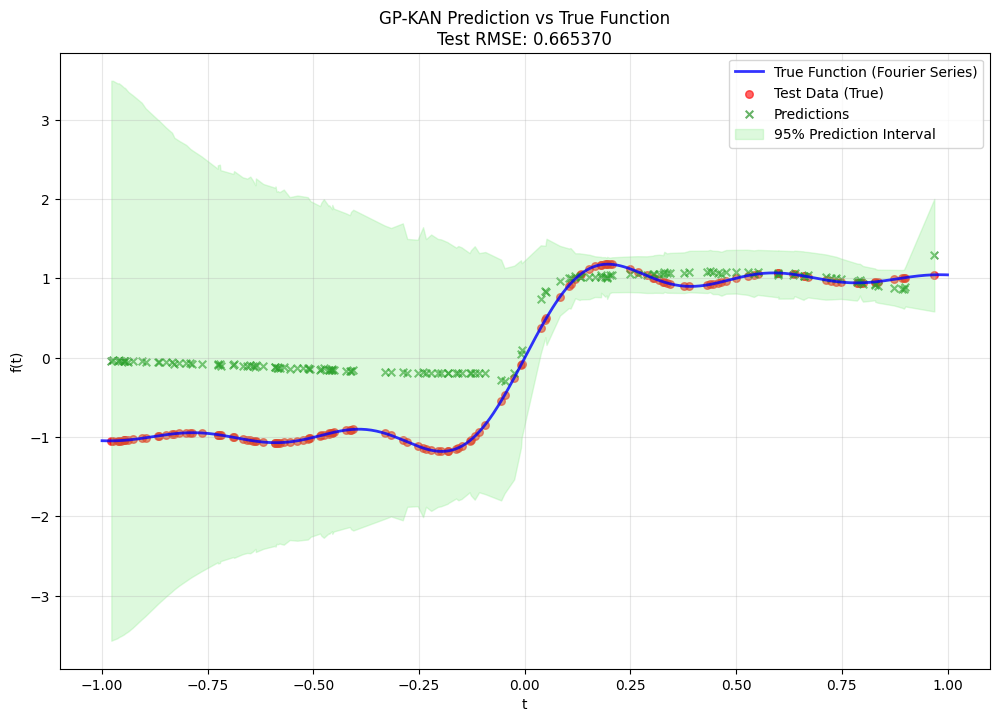

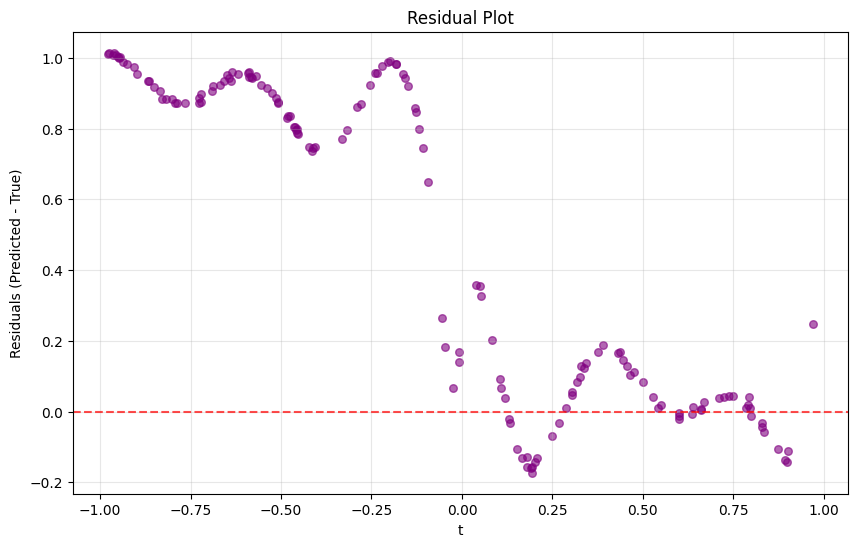


Residual Statistics:
Mean: 0.497727
Std: 0.441571
Min: -0.172816
Max: 1.014255
plot completed
epoch 0  , train negloglik: 0.32874,    val negloglik: 0.26443    accuracy: 0.3687 lr: [0.0001]
epoch 1  , train negloglik: 0.32478,    val negloglik: 0.25236    accuracy: 0.3691 lr: [9e-05]
epoch 2  , train negloglik: 0.32387,    val negloglik: 0.26363    accuracy: 0.3663 lr: [9e-05]
epoch 3  , train negloglik: 0.33376,    val negloglik: 0.23939    accuracy: 0.3787 lr: [9e-05]
epoch 4  , train negloglik: 0.31666,    val negloglik: 0.22708    accuracy: 0.3702 lr: [9e-05]
epoch 5  , train negloglik: 0.31277,    val negloglik: 0.23601    accuracy: 0.3599 lr: [9e-05]
epoch 6  , train negloglik: 0.30541,    val negloglik: 0.22225    accuracy: 0.3580 lr: [9e-05]
epoch 7  , train negloglik: 0.28531,    val negloglik: 0.21531    accuracy: 0.3593 lr: [9e-05]
epoch 8  , train negloglik: 0.29634,    val negloglik: 0.21398    accuracy: 0.3594 lr: [9e-05]
epoch 9  , train negloglik: 0.27648,    val neglo

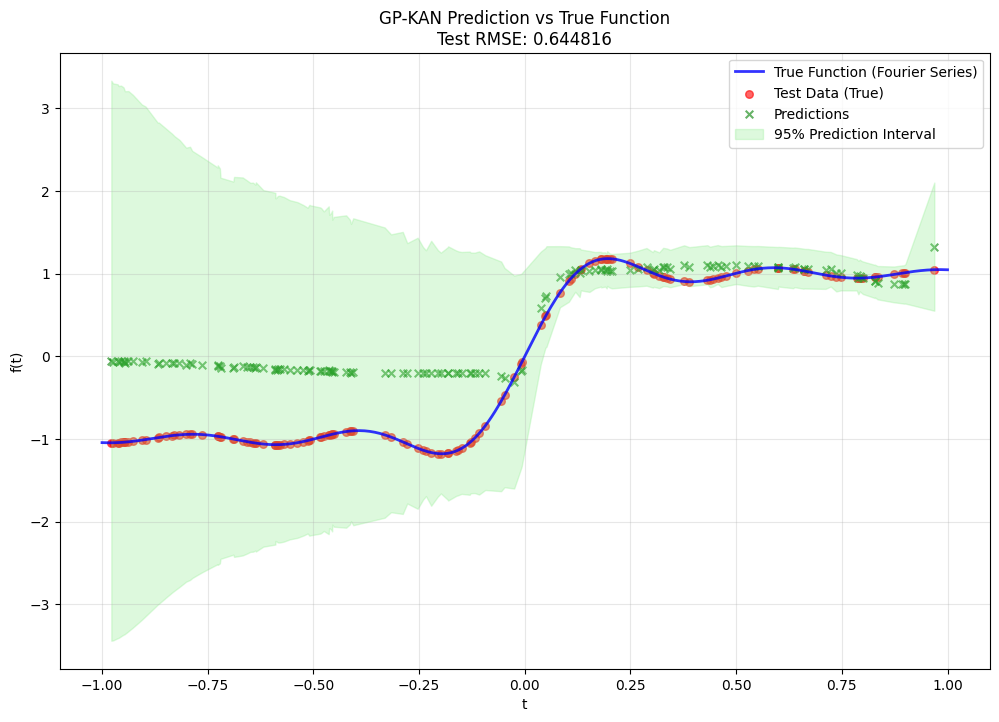

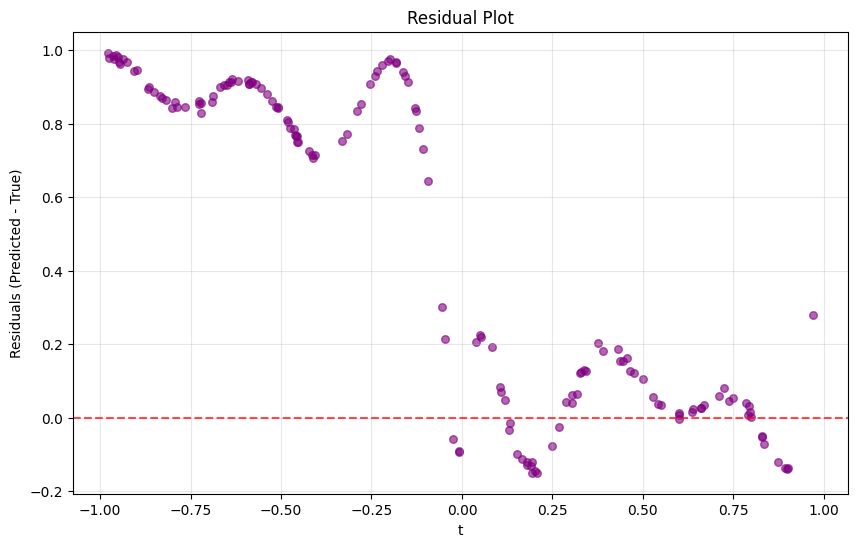


Residual Statistics:
Mean: 0.480548
Std: 0.429955
Min: -0.149533
Max: 0.992681
plot completed


In [ ]:
# 10エポックずつ学習を行い、カーネル行列のランクを可視化する
rank_list_layer0 = []
condition_number_list_layer0 = []
eigenvals_list_layer0 = []

rank_list_layer1 = []
condition_number_list_layer1 = []
eigenvals_list_layer1 = []

for epoch in range(10):
    runner.train_model(
        train_dataloader,
        val_dataloader,
        model,
        epochs=10,
        learning_rate=1e-4,
        use_gpu=False,  # True,
        pretrain=False,  # True,
        global_jitter=1e-3,
        baseline_jitter=1e-3,
    )
    model.save_model()  # optionally save the model after training

    # カーネル行列のランクを計算 (Layer 0)
    rank_0, condition_number_0, eigenvals_0 = compute_kernel_rank(model, depth=0)
    rank_list_layer0.append(rank_0)
    condition_number_list_layer0.append(condition_number_0)
    eigenvals_list_layer0.append(eigenvals_0)

    # カーネル行列のランクを計算 (Layer 1)
    rank_1, condition_number_1, eigenvals_1 = compute_kernel_rank(model, depth=1)
    rank_list_layer1.append(rank_1)
    condition_number_list_layer1.append(condition_number_1)
    eigenvals_list_layer1.append(eigenvals_1)

    # 可視化
    plot_result(model)

epoch 0  , train negloglik: 0.27446,    val negloglik: 0.20853    accuracy: 0.3494 lr: [0.0001]
epoch 1  , train negloglik: 0.28045,    val negloglik: 0.19839    accuracy: 0.3511 lr: [9e-05]
epoch 2  , train negloglik: 0.28194,    val negloglik: 0.24091    accuracy: 0.3513 lr: [9e-05]
epoch 3  , train negloglik: 0.25953,    val negloglik: 0.19836    accuracy: 0.3403 lr: [9e-05]
epoch 4  , train negloglik: 0.26331,    val negloglik: 0.19406    accuracy: 0.3326 lr: [9e-05]
epoch 5  , train negloglik: 0.26819,    val negloglik: 0.21155    accuracy: 0.3378 lr: [9e-05]
epoch 6  , train negloglik: 0.24988,    val negloglik: 0.21243    accuracy: 0.3307 lr: [9e-05]
epoch 7  , train negloglik: 0.24400,    val negloglik: 0.20212    accuracy: 0.3253 lr: [9e-05]
epoch 8  , train negloglik: 0.25113,    val negloglik: 0.18256    accuracy: 0.3272 lr: [9e-05]
epoch 9  , train negloglik: 0.24291,    val negloglik: 0.17811    accuracy: 0.3238 lr: [9e-05]
Test MSE: 0.392636
Test RMSE: 0.626607


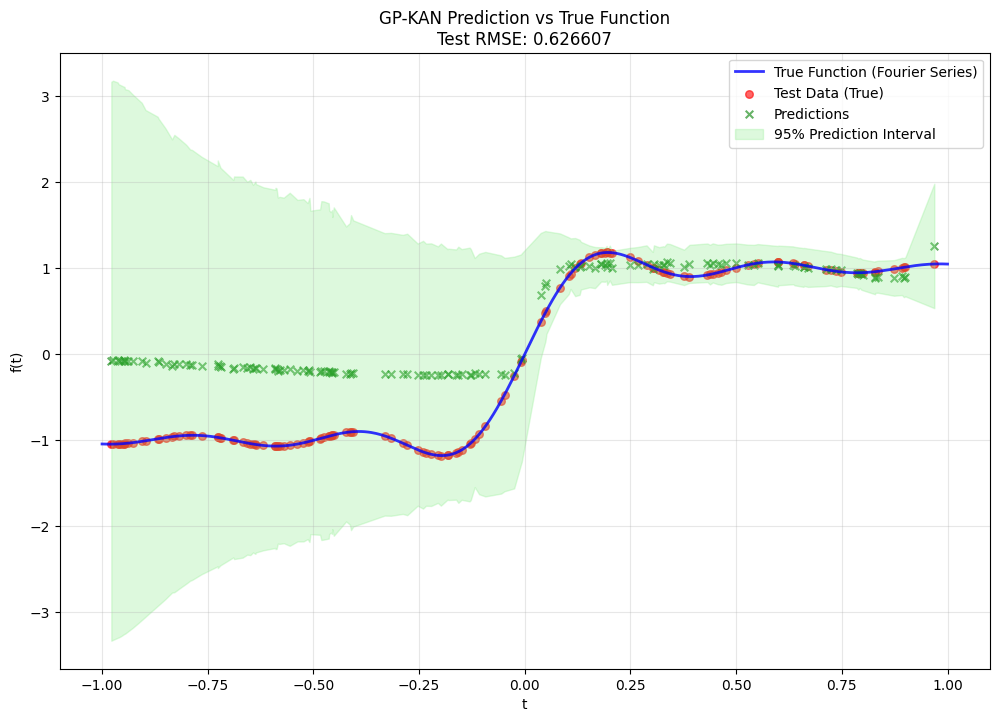

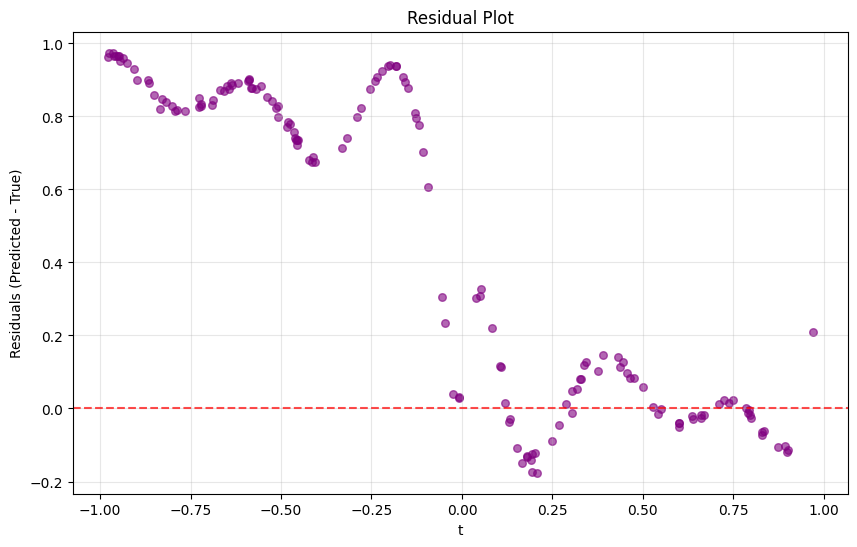


Residual Statistics:
Mean: 0.460766
Std: 0.424653
Min: -0.175938
Max: 0.974596
plot completed
epoch 0  , train negloglik: 0.23198,    val negloglik: 0.15731    accuracy: 0.3158 lr: [0.0001]
epoch 1  , train negloglik: 0.23129,    val negloglik: 0.17233    accuracy: 0.3195 lr: [9e-05]
epoch 2  , train negloglik: 0.22558,    val negloglik: 0.14651    accuracy: 0.3164 lr: [9e-05]
epoch 3  , train negloglik: 0.22050,    val negloglik: 0.15859    accuracy: 0.3203 lr: [9e-05]
epoch 4  , train negloglik: 0.22411,    val negloglik: 0.18966    accuracy: 0.3025 lr: [9e-05]
epoch 5  , train negloglik: 0.21454,    val negloglik: 0.16045    accuracy: 0.3060 lr: [9e-05]
epoch 6  , train negloglik: 0.23935,    val negloglik: 0.15770    accuracy: 0.3063 lr: [9e-05]
epoch 7  , train negloglik: 0.23097,    val negloglik: 0.12760    accuracy: 0.3031 lr: [9e-05]
epoch 8  , train negloglik: 0.20712,    val negloglik: 0.14007    accuracy: 0.2899 lr: [9e-05]
epoch 9  , train negloglik: 0.18036,    val neglo

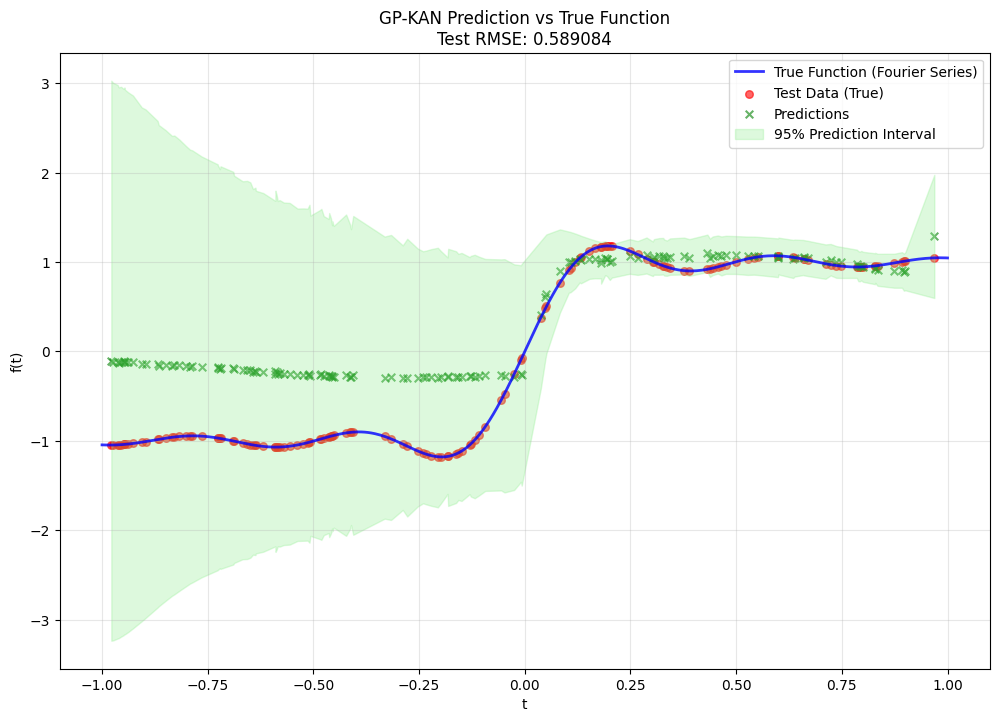

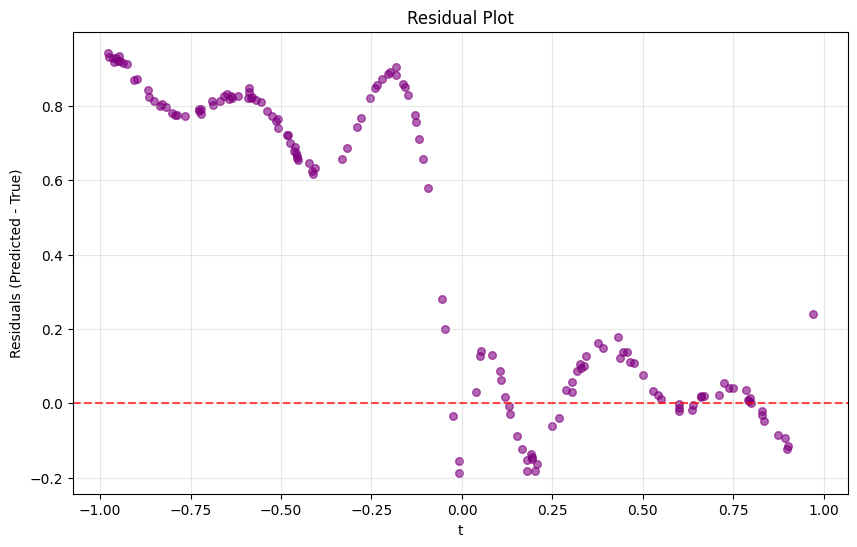


Residual Statistics:
Mean: 0.431556
Std: 0.400973
Min: -0.186937
Max: 0.943400
plot completed
epoch 0  , train negloglik: 0.18747,    val negloglik: 0.14678    accuracy: 0.2768 lr: [0.0001]
epoch 1  , train negloglik: 0.18006,    val negloglik: 0.13896    accuracy: 0.2813 lr: [9e-05]
epoch 2  , train negloglik: 0.17287,    val negloglik: 0.13337    accuracy: 0.2758 lr: [9e-05]
epoch 3  , train negloglik: 0.20200,    val negloglik: 0.16130    accuracy: 0.2739 lr: [9e-05]
epoch 4  , train negloglik: 0.18219,    val negloglik: 0.09554    accuracy: 0.2696 lr: [9e-05]
epoch 5  , train negloglik: 0.17650,    val negloglik: 0.07922    accuracy: 0.2606 lr: [9e-05]
epoch 6  , train negloglik: 0.19269,    val negloglik: 0.07471    accuracy: 0.2594 lr: [9e-05]
epoch 7  , train negloglik: 0.15996,    val negloglik: 0.09322    accuracy: 0.2532 lr: [9e-05]
epoch 8  , train negloglik: 0.15205,    val negloglik: 0.06084    accuracy: 0.2502 lr: [9e-05]
epoch 9  , train negloglik: 0.15467,    val neglo

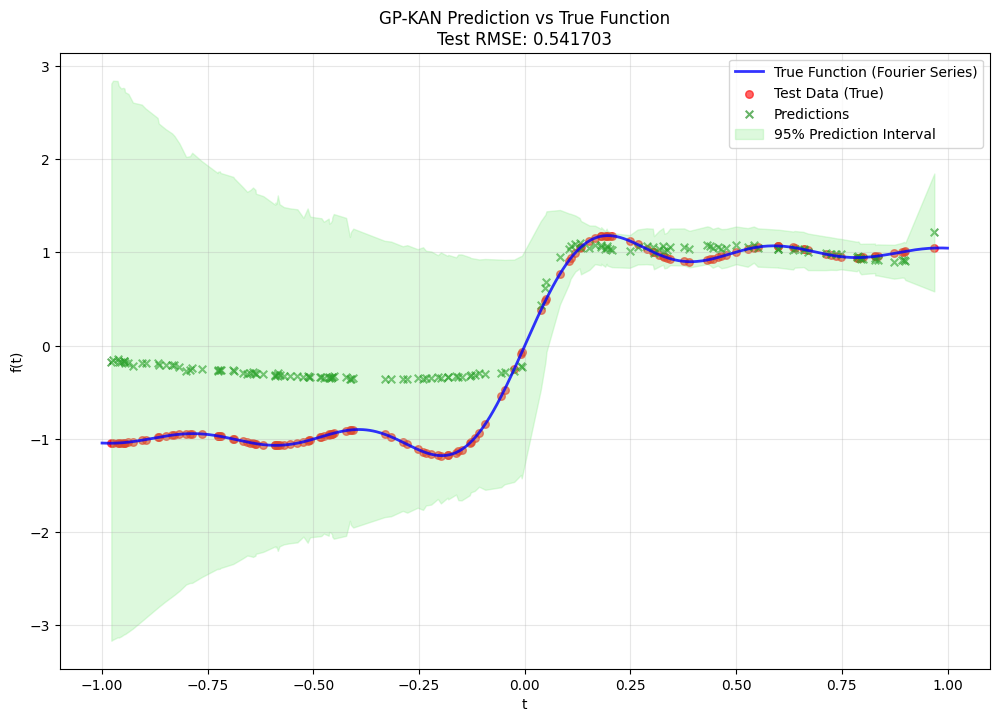

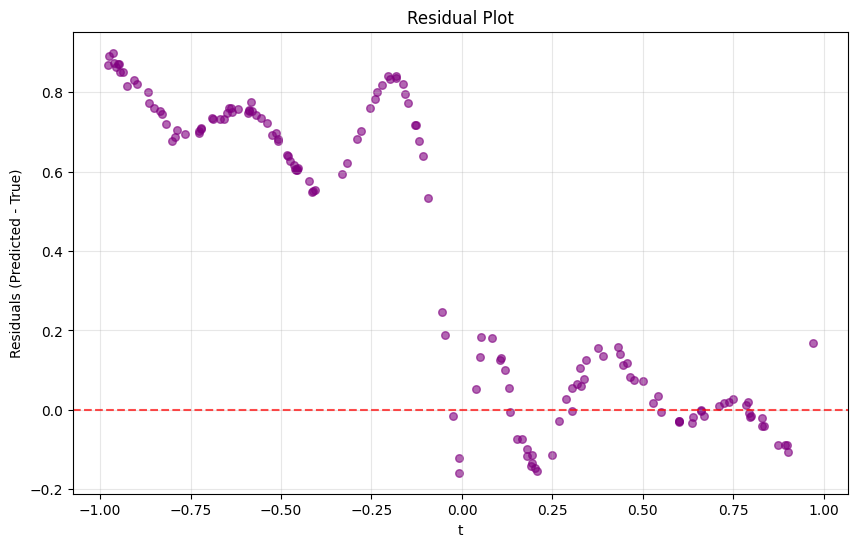


Residual Statistics:
Mean: 0.397111
Std: 0.368436
Min: -0.158574
Max: 0.899617
plot completed
epoch 0  , train negloglik: 0.13294,    val negloglik: 0.08998    accuracy: 0.2432 lr: [0.0001]
epoch 1  , train negloglik: 0.13257,    val negloglik: 0.10662    accuracy: 0.2321 lr: [9e-05]
epoch 2  , train negloglik: 0.13696,    val negloglik: 0.04479    accuracy: 0.2198 lr: [9e-05]
epoch 3  , train negloglik: 0.12247,    val negloglik: 0.04121    accuracy: 0.2158 lr: [9e-05]
epoch 4  , train negloglik: 0.12640,    val negloglik: 0.02784    accuracy: 0.2191 lr: [9e-05]
epoch 5  , train negloglik: 0.10900,    val negloglik: 0.06283    accuracy: 0.2142 lr: [9e-05]
epoch 6  , train negloglik: 0.15292,    val negloglik: 0.05124    accuracy: 0.2009 lr: [9e-05]
epoch 7  , train negloglik: 0.16443,    val negloglik: 0.14059    accuracy: 0.2001 lr: [9e-05]
epoch 8  , train negloglik: 0.13015,    val negloglik: 0.03307    accuracy: 0.2071 lr: [9e-05]
epoch 9  , train negloglik: 0.11571,    val neglo

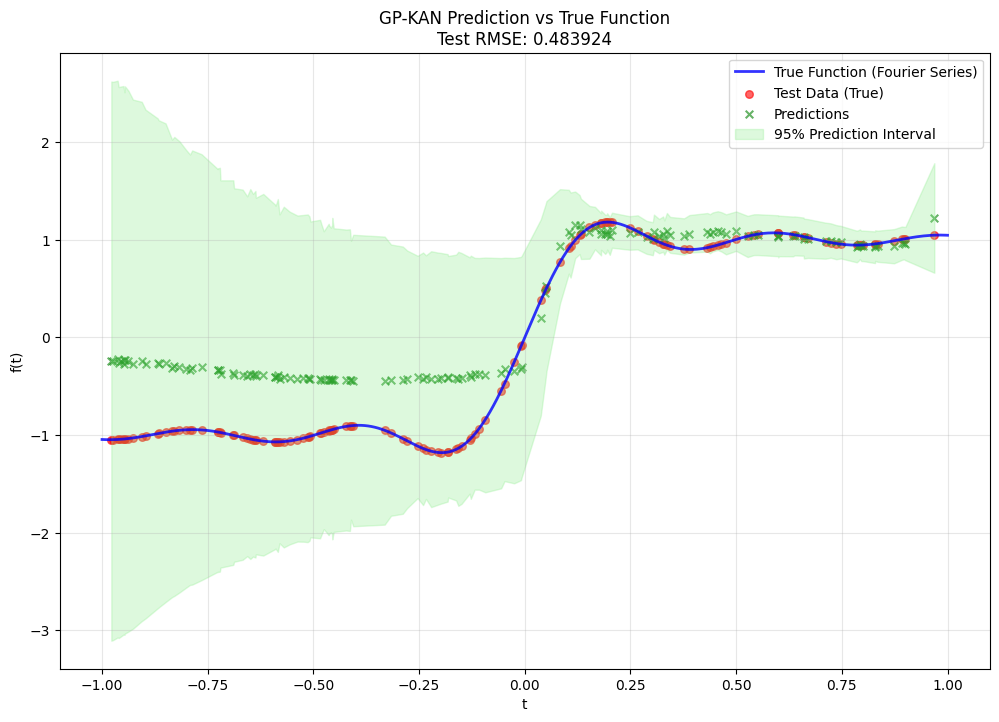

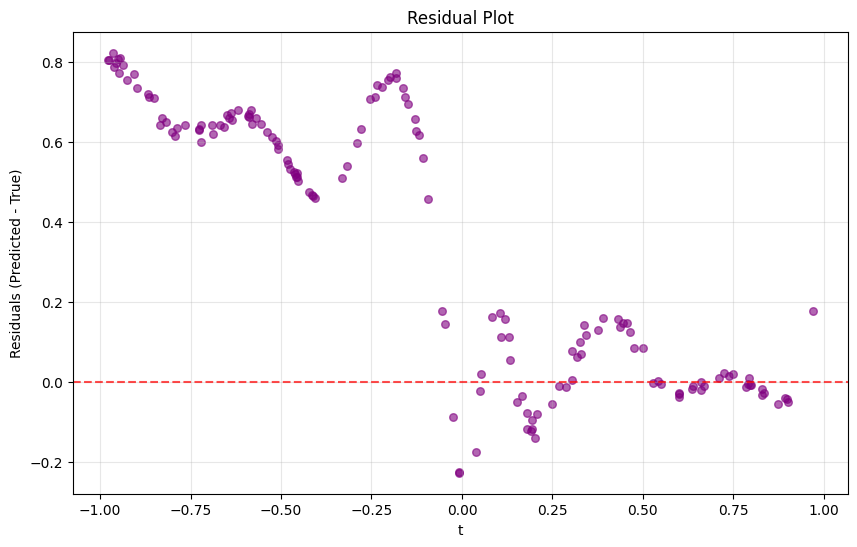


Residual Statistics:
Mean: 0.352956
Std: 0.331065
Min: -0.227286
Max: 0.823006
plot completed
epoch 0  , train negloglik: 0.06498,    val negloglik: 0.00590    accuracy: 0.1859 lr: [0.0001]
epoch 1  , train negloglik: 0.07806,    val negloglik: 0.02731    accuracy: 0.1817 lr: [9e-05]
epoch 2  , train negloglik: 0.14557,    val negloglik: -0.01346    accuracy: 0.1687 lr: [9e-05]
epoch 3  , train negloglik: 0.04780,    val negloglik: 0.00564    accuracy: 0.1684 lr: [9e-05]
epoch 4  , train negloglik: 0.05453,    val negloglik: -0.01848    accuracy: 0.1566 lr: [9e-05]
epoch 5  , train negloglik: 0.02680,    val negloglik: -0.03282    accuracy: 0.1471 lr: [9e-05]
epoch 6  , train negloglik: 0.04513,    val negloglik: -0.07246    accuracy: 0.1434 lr: [9e-05]
epoch 7  , train negloglik: 0.02238,    val negloglik: -0.08045    accuracy: 0.1397 lr: [9e-05]
epoch 8  , train negloglik: 0.02247,    val negloglik: -0.09766    accuracy: 0.1326 lr: [9e-05]
epoch 9  , train negloglik: 0.01084,    val

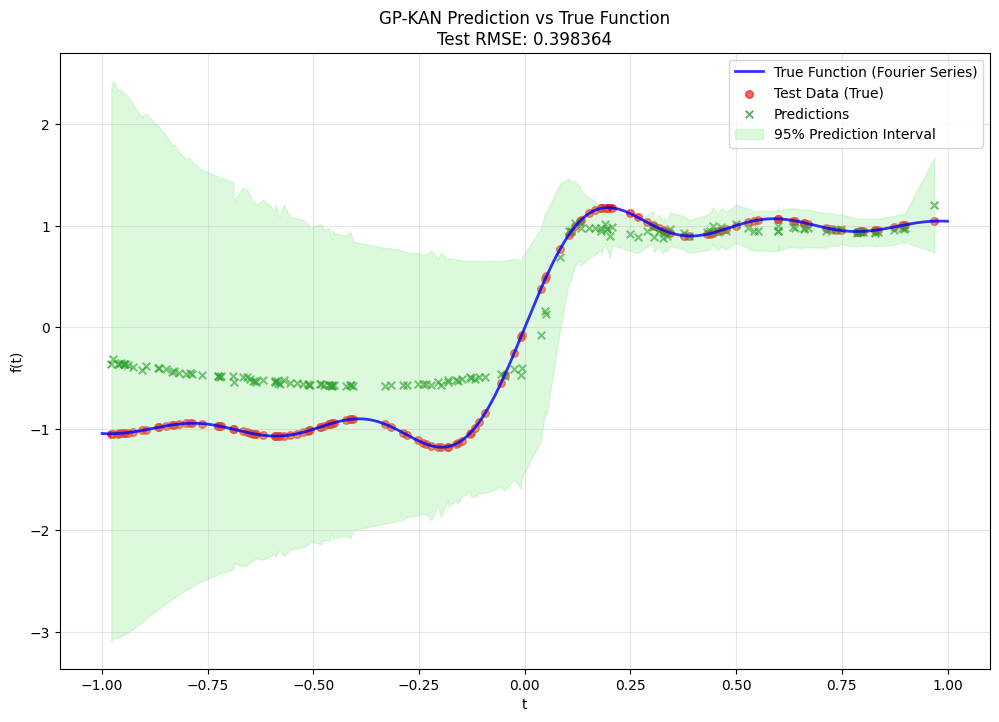

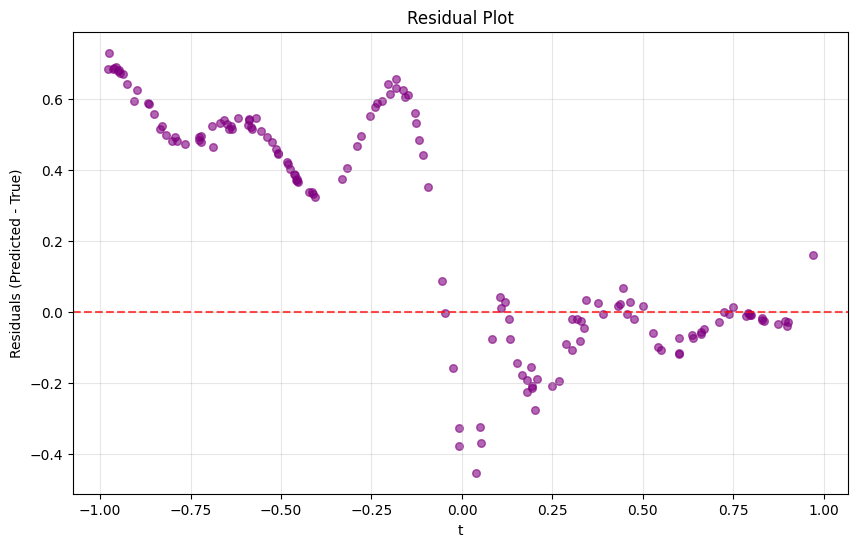


Residual Statistics:
Mean: 0.241851
Std: 0.316547
Min: -0.453075
Max: 0.731409
plot completed
epoch 0  , train negloglik: -0.00621,    val negloglik: 0.03744    accuracy: 0.1317 lr: [0.0001]
epoch 1  , train negloglik: 0.01336,    val negloglik: -0.12694    accuracy: 0.1198 lr: [9e-05]
epoch 2  , train negloglik: 0.00009,    val negloglik: 0.02155    accuracy: 0.1187 lr: [9e-05]
epoch 3  , train negloglik: 0.01994,    val negloglik: -0.15162    accuracy: 0.1120 lr: [9e-05]
epoch 4  , train negloglik: -0.00325,    val negloglik: -0.11184    accuracy: 0.1058 lr: [9e-05]
epoch 5  , train negloglik: -0.01631,    val negloglik: -0.15265    accuracy: 0.0999 lr: [9e-05]
epoch 6  , train negloglik: -0.05091,    val negloglik: -0.09413    accuracy: 0.0943 lr: [9e-05]
epoch 7  , train negloglik: -0.02642,    val negloglik: -0.09751    accuracy: 0.1005 lr: [9e-05]
epoch 8  , train negloglik: -0.05834,    val negloglik: -0.16248    accuracy: 0.0906 lr: [9e-05]
epoch 9  , train negloglik: -0.05831

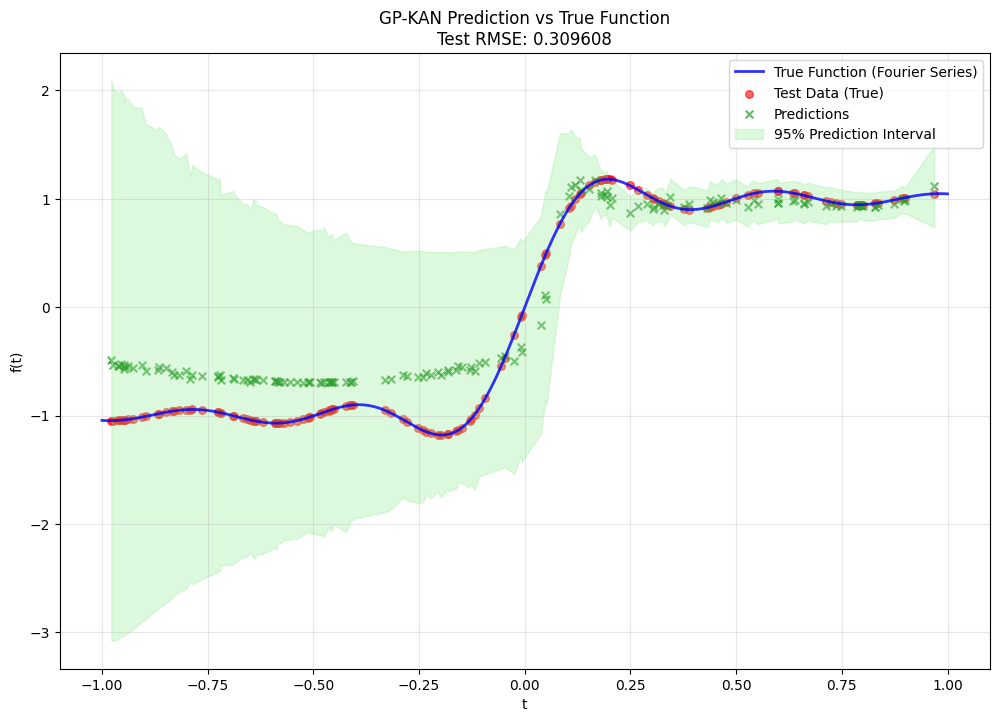

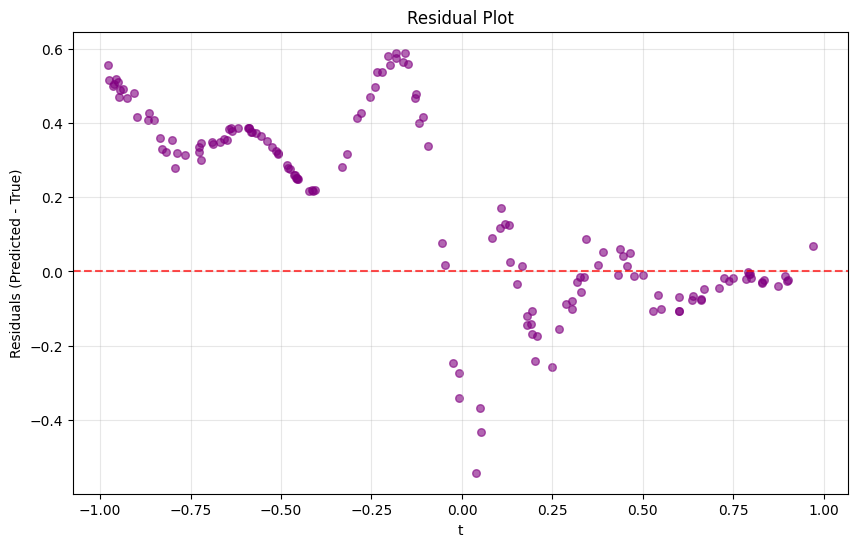


Residual Statistics:
Mean: 0.179880
Std: 0.251992
Min: -0.543173
Max: 0.590454
plot completed
epoch 0  , train negloglik: -0.09097,    val negloglik: -0.23002    accuracy: 0.0783 lr: [0.0001]
epoch 1  , train negloglik: -0.07581,    val negloglik: -0.21294    accuracy: 0.0763 lr: [9e-05]
epoch 2  , train negloglik: -0.05203,    val negloglik: -0.14656    accuracy: 0.0835 lr: [9e-05]
epoch 3  , train negloglik: -0.07925,    val negloglik: -0.21680    accuracy: 0.0709 lr: [9e-05]
epoch 4  , train negloglik: -0.07282,    val negloglik: -0.22615    accuracy: 0.0745 lr: [9e-05]
epoch 5  , train negloglik: -0.07611,    val negloglik: -0.20040    accuracy: 0.0685 lr: [9e-05]
epoch 6  , train negloglik: -0.08767,    val negloglik: -0.24019    accuracy: 0.0644 lr: [9e-05]
epoch 7  , train negloglik: -0.11925,    val negloglik: -0.13047    accuracy: 0.0608 lr: [9e-05]
epoch 8  , train negloglik: -0.12816,    val negloglik: -0.20122    accuracy: 0.0691 lr: [9e-05]
epoch 9  , train negloglik: -0.

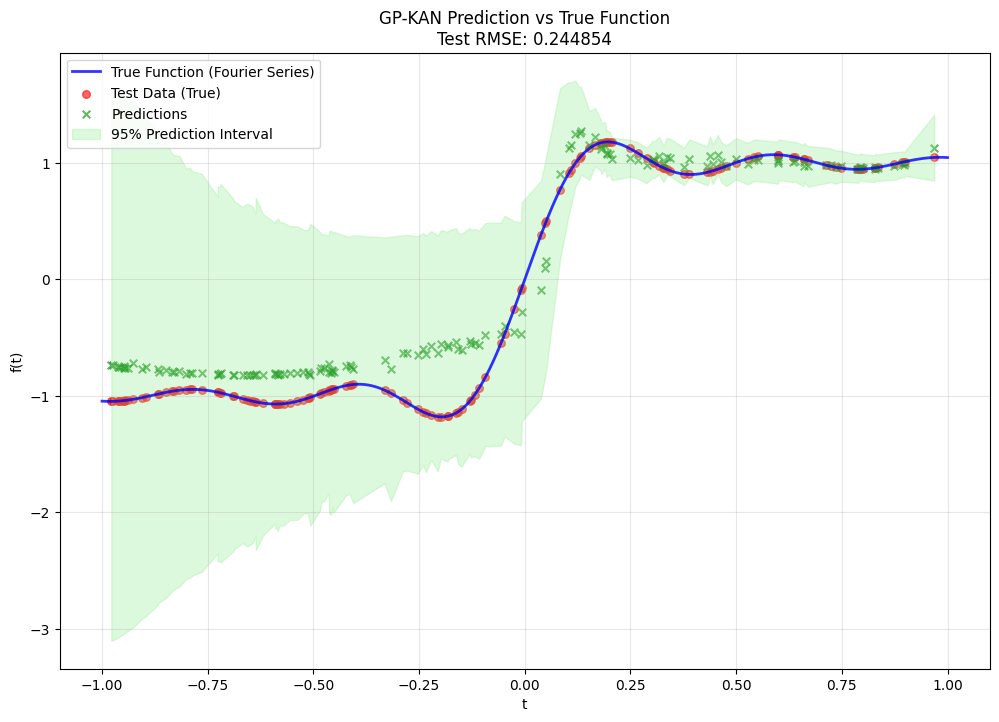

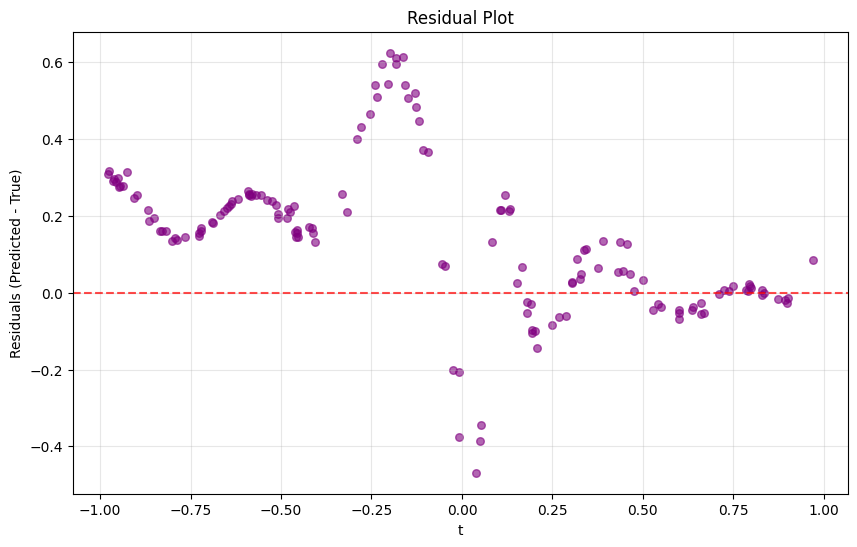


Residual Statistics:
Mean: 0.145908
Std: 0.196632
Min: -0.468664
Max: 0.624800
plot completed
epoch 0  , train negloglik: -0.11684,    val negloglik: -0.22389    accuracy: 0.0557 lr: [0.0001]
epoch 1  , train negloglik: -0.13192,    val negloglik: -0.11692    accuracy: 0.0753 lr: [9e-05]
epoch 2  , train negloglik: -0.18640,    val negloglik: -0.27568    accuracy: 0.0564 lr: [9e-05]
epoch 3  , train negloglik: -0.17336,    val negloglik: -0.17457    accuracy: 0.0705 lr: [9e-05]
epoch 4  , train negloglik: -0.11919,    val negloglik: -0.20935    accuracy: 0.0617 lr: [9e-05]
epoch 5  , train negloglik: -0.09434,    val negloglik: -0.14960    accuracy: 0.0698 lr: [9e-05]
epoch 6  , train negloglik: -0.17165,    val negloglik: -0.12233    accuracy: 0.0763 lr: [9e-05]
epoch 7  , train negloglik: -0.21461,    val negloglik: -0.34132    accuracy: 0.0501 lr: [9e-05]
epoch 8  , train negloglik: -0.22145,    val negloglik: -0.35507    accuracy: 0.0474 lr: [9e-05]
epoch 9  , train negloglik: -0.

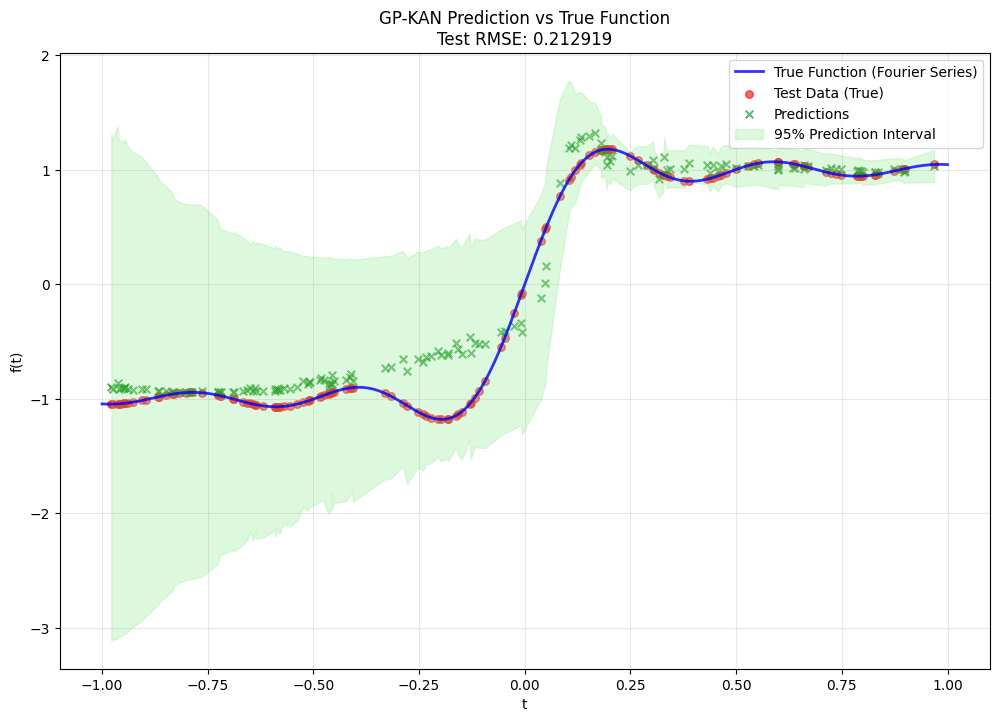

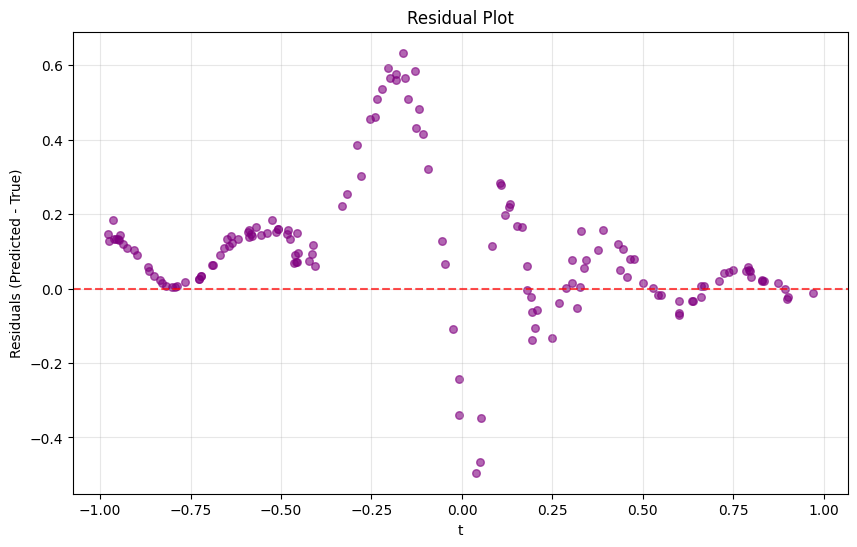


Residual Statistics:
Mean: 0.106299
Std: 0.184486
Min: -0.494915
Max: 0.633669
plot completed
epoch 0  , train negloglik: -0.16873,    val negloglik: -0.32664    accuracy: 0.0440 lr: [0.0001]
epoch 1  , train negloglik: -0.18120,    val negloglik: -0.31355    accuracy: 0.0533 lr: [9e-05]
epoch 2  , train negloglik: -0.21016,    val negloglik: -0.34173    accuracy: 0.0510 lr: [9e-05]
epoch 3  , train negloglik: -0.23354,    val negloglik: -0.06088    accuracy: 0.0402 lr: [9e-05]
epoch 4  , train negloglik: -0.22490,    val negloglik: -0.20753    accuracy: 0.0409 lr: [9e-05]
epoch 5  , train negloglik: -0.23235,    val negloglik: -0.31024    accuracy: 0.0553 lr: [9e-05]
epoch 6  , train negloglik: -0.26230,    val negloglik: -0.38577    accuracy: 0.0479 lr: [9e-05]
epoch 7  , train negloglik: -0.25725,    val negloglik: -0.29330    accuracy: 0.0610 lr: [9e-05]
epoch 8  , train negloglik: -0.24339,    val negloglik: -0.35562    accuracy: 0.0392 lr: [9e-05]
epoch 9  , train negloglik: -0.

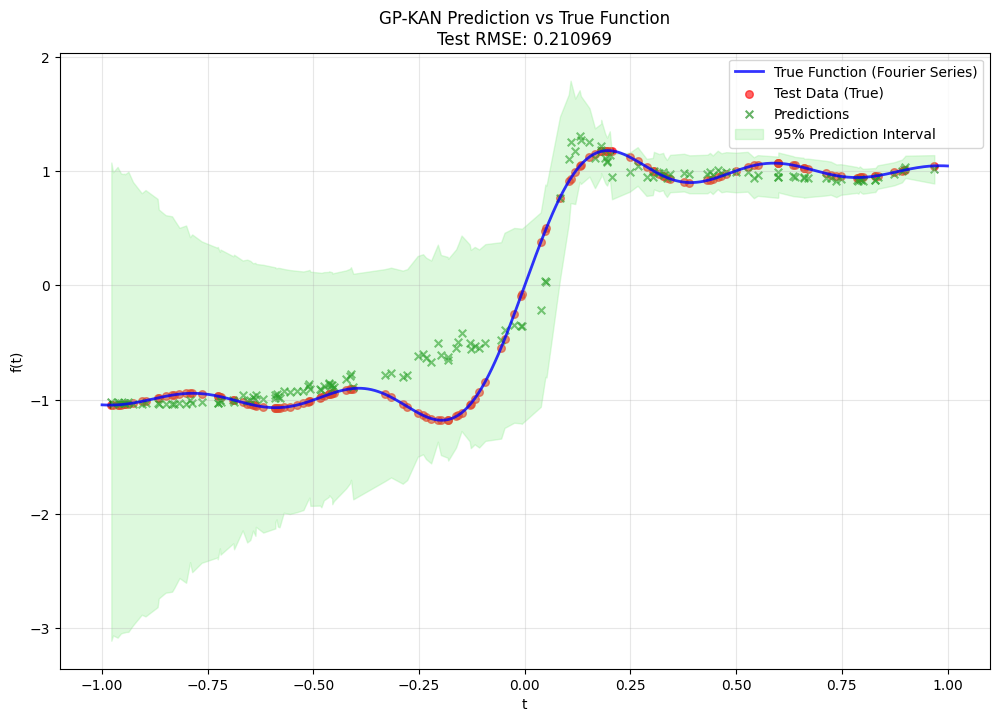

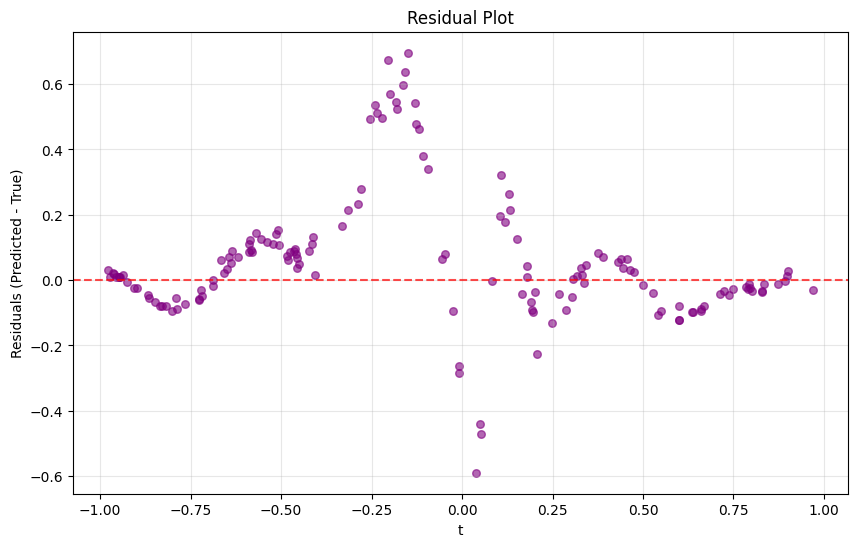


Residual Statistics:
Mean: 0.059643
Std: 0.202363
Min: -0.589557
Max: 0.696086
plot completed
epoch 0  , train negloglik: -0.25726,    val negloglik: -0.35752    accuracy: 0.0540 lr: [0.0001]
epoch 1  , train negloglik: -0.24915,    val negloglik: -0.22251    accuracy: 0.0622 lr: [9e-05]
epoch 2  , train negloglik: -0.22994,    val negloglik: -0.29204    accuracy: 0.0491 lr: [9e-05]
epoch 3  , train negloglik: -0.21475,    val negloglik: -0.38256    accuracy: 0.0432 lr: [9e-05]
epoch 4  , train negloglik: -0.29013,    val negloglik: -0.11442    accuracy: 0.0745 lr: [9e-05]
epoch 5  , train negloglik: -0.22175,    val negloglik: -0.37190    accuracy: 0.0565 lr: [9e-05]
epoch 6  , train negloglik: -0.26921,    val negloglik: -0.11871    accuracy: 0.0787 lr: [9e-05]
epoch 7  , train negloglik: -0.25760,    val negloglik: -0.36534    accuracy: 0.0417 lr: [9e-05]
epoch 8  , train negloglik: -0.27048,    val negloglik: -0.38188    accuracy: 0.0389 lr: [9e-05]
epoch 9  , train negloglik: -0.

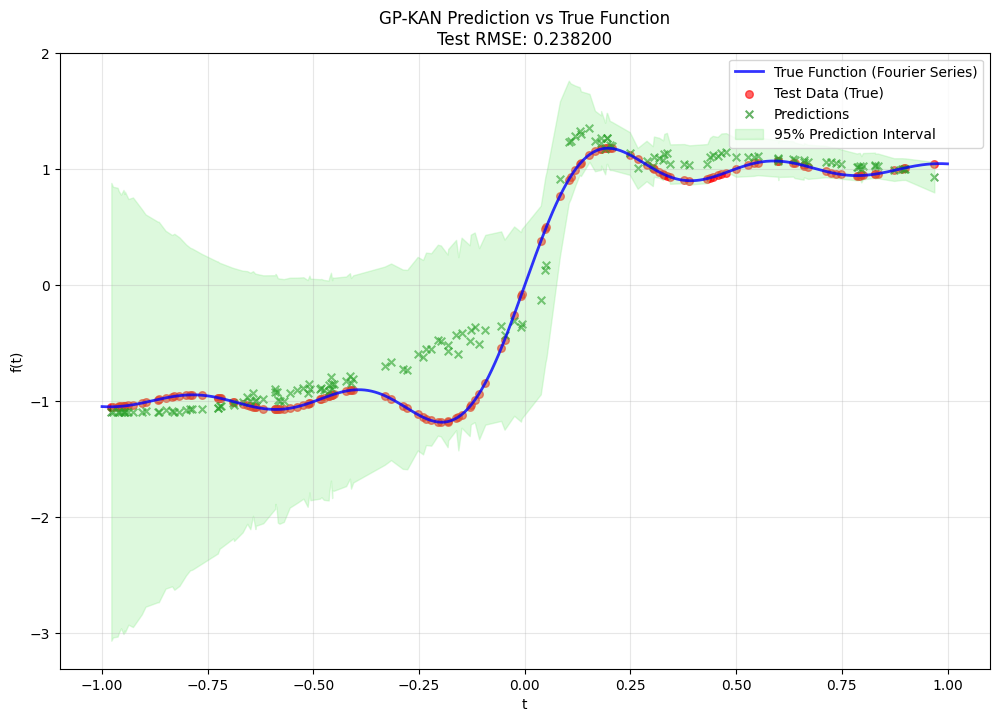

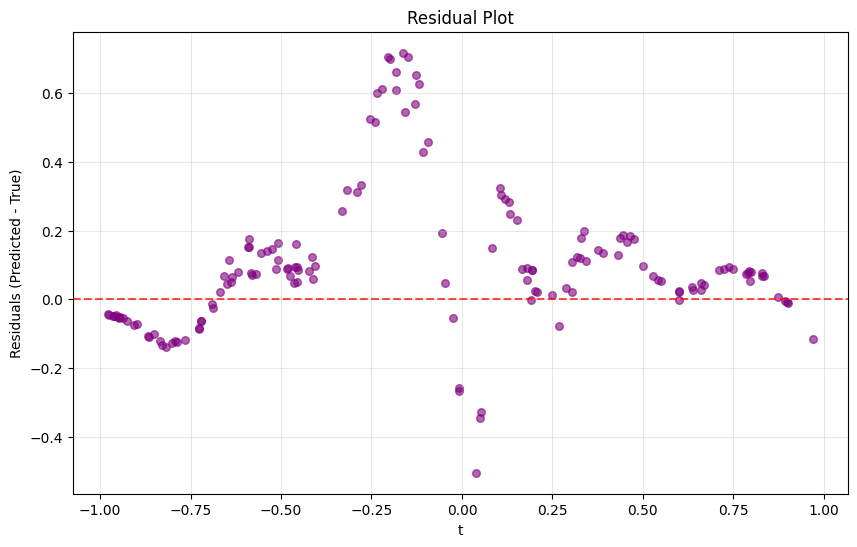


Residual Statistics:
Mean: 0.106104
Std: 0.213263
Min: -0.505231
Max: 0.718079
plot completed


In [ ]:
# 10エポックずつ学習を行い、カーネル行列のランクを可視化する
rank_list_layer0 = []
condition_number_list_layer0 = []
eigenvals_list_layer0 = []

rank_list_layer1 = []
condition_number_list_layer1 = []
eigenvals_list_layer1 = []

for epoch in range(10):
    runner.train_model(
        train_dataloader,
        val_dataloader,
        model,
        epochs=10,
        learning_rate=1e-4,
        use_gpu=False,  # True,
        pretrain=False,  # True,
        global_jitter=1e-3,
        baseline_jitter=1e-3,
    )
    model.save_model()  # optionally save the model after training

    # カーネル行列のランクを計算 (Layer 0)
    rank_0, condition_number_0, eigenvals_0 = compute_kernel_rank(model, depth=0)
    rank_list_layer0.append(rank_0)
    condition_number_list_layer0.append(condition_number_0)
    eigenvals_list_layer0.append(eigenvals_0)

    # カーネル行列のランクを計算 (Layer 1)
    rank_1, condition_number_1, eigenvals_1 = compute_kernel_rank(model, depth=1)
    rank_list_layer1.append(rank_1)
    condition_number_list_layer1.append(condition_number_1)
    eigenvals_list_layer1.append(eigenvals_1)

    # 可視化
    plot_result(model)

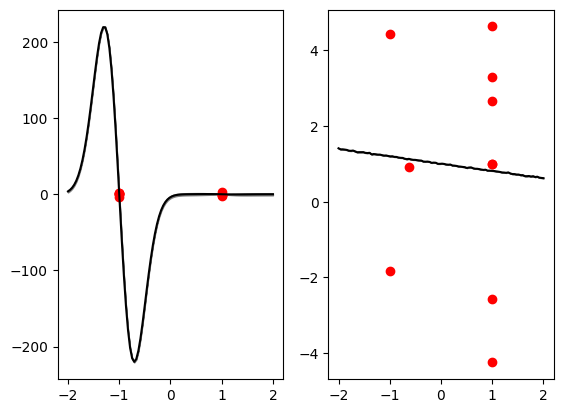

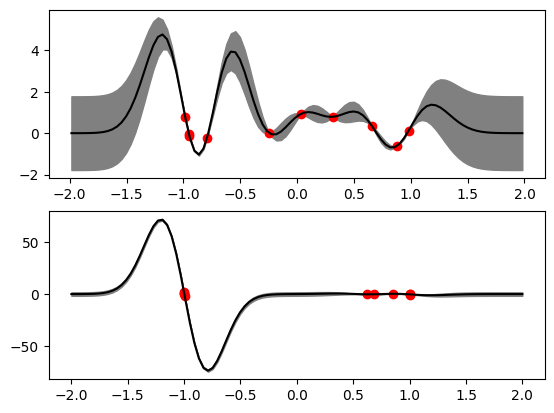

In [ ]:
# 1層目
model.layers[0].save_fig("./outputs/layer_fused0.png")
model.layers[1].save_fig("./outputs/layer_fused1.png")

### 2-3.精度評価

In [ ]:
# 学習における対数周辺尤度の最適化について
print("=== 誘導点最適化の仕組み ===")
print("1. 対数周辺尤度を目的関数として使用")
print("   log p(y|X,θ) = -0.5*y^T*K^(-1)*y - 0.5*log|K| - (n/2)*log(2π)")
print("2. 誘導点の位置 z が K に影響")
print("3. 勾配降下法により z を最適化")
print()

# 学習前後の誘導点位置を比較
print("=== 誘導点位置の変化 ===")
layer0 = model.layers[0]
layer1 = model.layers[1]

print("Layer 0 - 誘導点位置 (tanh変換後):")
z0 = layer0.get_z()  # tanh変換済み
print(f"  GP(0,0): {z0[0,0,:].detach().numpy()}")
print(f"  GP(0,1): {z0[0,1,:].detach().numpy()}")

print("\nLayer 1 - 誘導点位置 (tanh変換後):")
z1 = layer1.get_z()  # tanh変換済み
print(f"  GP(0,0): {z1[0,0,:].detach().numpy()}")
print(f"  GP(1,0): {z1[1,0,:].detach().numpy()}")

# 誘導点の初期値と比較するため、理論的初期値を計算
print("\n=== 理論的初期値との比較 ===")
initial_z = torch.linspace(-2, 2, 10)  # 初期化時の値
initial_z_tanh = torch.tanh(initial_z)  # tanh変換後
print(f"理論的初期値 (tanh変換後): {initial_z_tanh.numpy()}")

print("\n学習により誘導点が初期の等間隔配置から、")
print("データ分布により適した位置に移動していることが確認できます。")

=== 誘導点最適化の仕組み ===
1. 対数周辺尤度を目的関数として使用
   log p(y|X,θ) = -0.5*y^T*K^(-1)*y - 0.5*log|K| - (n/2)*log(2π)
2. 誘導点の位置 z が K に影響
3. 勾配降下法により z を最適化

=== 誘導点位置の変化 ===
Layer 0 - 誘導点位置 (tanh変換後):
  GP(0,0): [-0.99902546 -0.99999464 -1.         -1.         -1.          1.
  0.99999243 -0.998719    0.99999714  0.99999917]
  GP(0,1): [-1.         0.9970135  0.9997382  1.        -1.        -0.6274651
  0.9951571  1.         0.9999816  1.       ]

Layer 1 - 誘導点位置 (tanh変換後):
  GP(0,0): [-0.9848708  -0.9504901  -0.24493168 -0.7934707   0.03438086 -0.9474196
  0.3124296   0.6552589   0.88017476  0.98080194]
  GP(1,0): [-0.9995291  -0.9950042   0.683502    1.         -0.9999611  -0.9999989
  1.          0.62125474  0.8546779   0.9999997 ]

=== 理論的初期値との比較 ===
理論的初期値 (tanh変換後): [-0.9640276  -0.9146975  -0.8044548  -0.5827829  -0.21863507  0.21863507
  0.5827829   0.8044548   0.9146975   0.9640276 ]

学習により誘導点が初期の等間隔配置から、
データ分布により適した位置に移動していることが確認できます。


### 2-4.カーネル逆行列のランク推移

=== カーネル行列のランク推移 ===


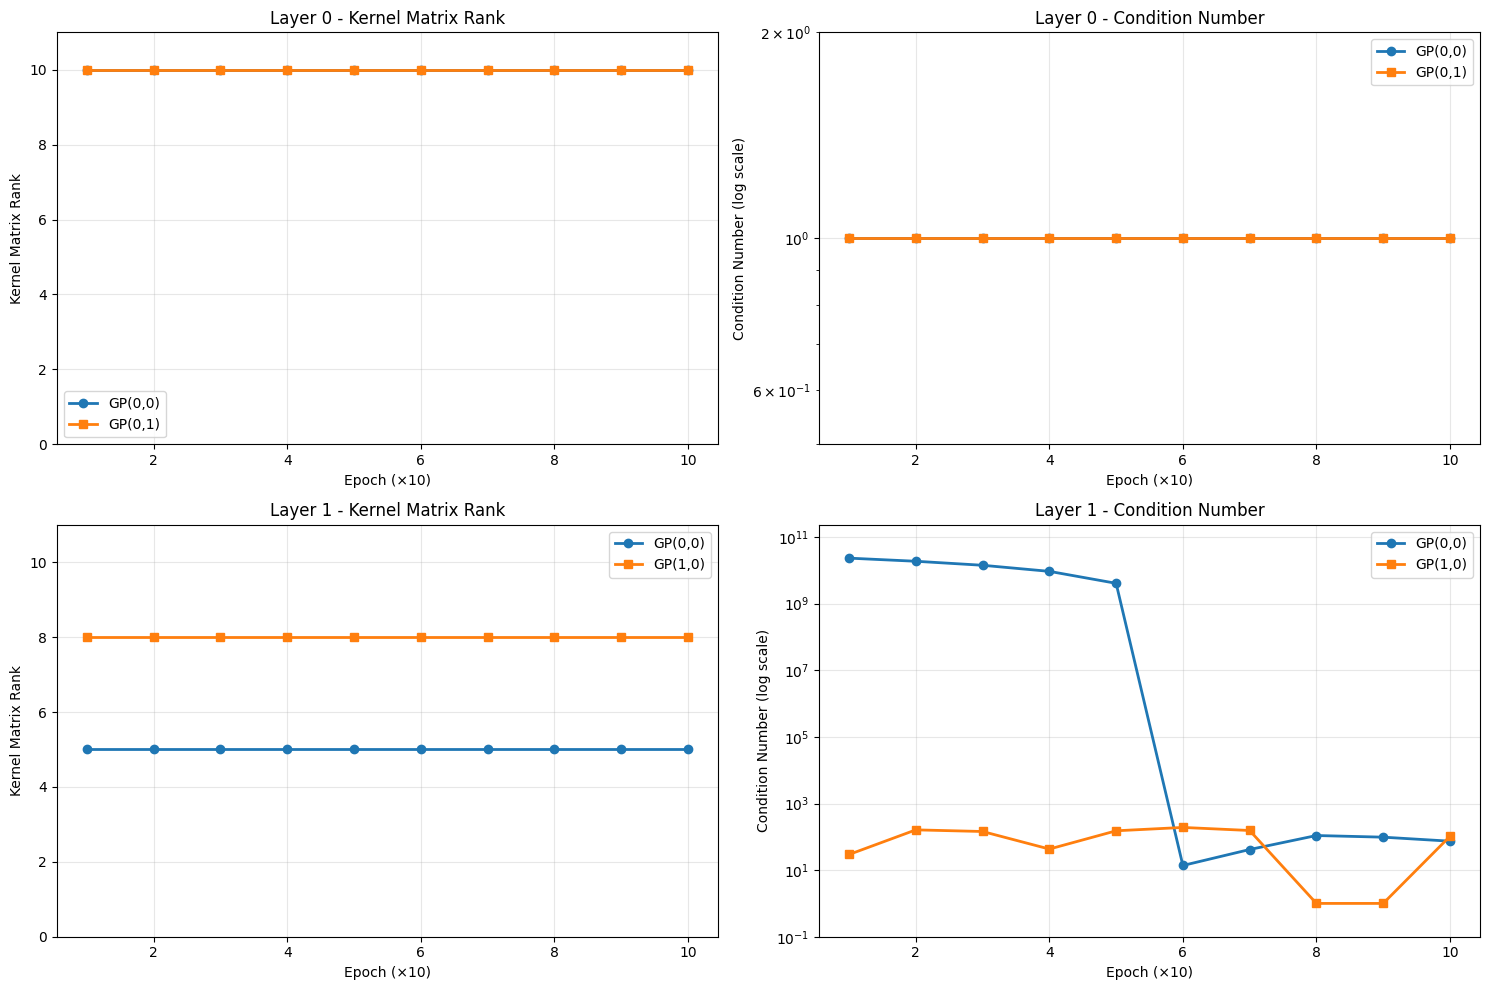


=== 最終エポックでの固有値分布 ===


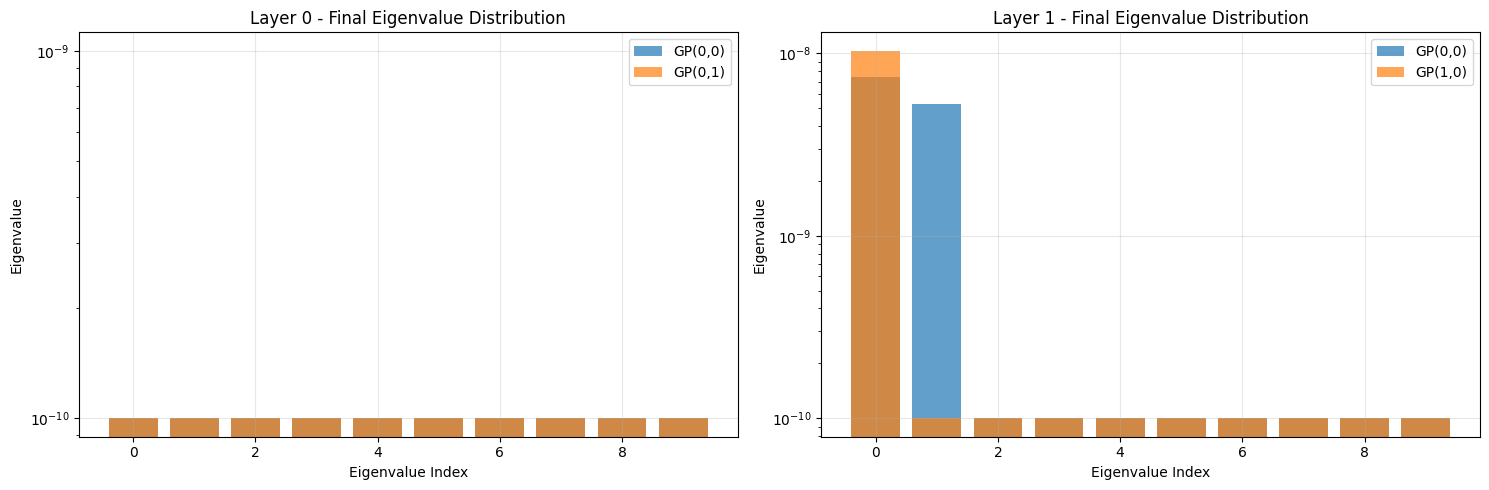


=== 分析結果 ===
1. ランクの変化：学習に伴いカーネル行列の数値的ランクが変化
2. 条件数の変化：誘導点の最適化により条件数が改善/悪化
3. 固有値分布：最適化後の固有値の分布特性
4. これらの変化は対数周辺尤度の最大化により駆動される


In [10]:
# カーネル行列のランク推移を可視化
import matplotlib.pyplot as plt
import numpy as np

epochs = list(range(1, 11))  # 1-10 epochs

print("=== カーネル行列のランク推移 ===")

# Layer 0のランク推移
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Layer 0 - ランク推移
rank_layer0_gp0 = [ranks[0] for ranks in rank_list_layer0]
rank_layer0_gp1 = [ranks[1] for ranks in rank_list_layer0]

axes[0, 0].plot(
    epochs, rank_layer0_gp0, "o-", label="GP(0,0)", linewidth=2, markersize=6
)
axes[0, 0].plot(
    epochs, rank_layer0_gp1, "s-", label="GP(0,1)", linewidth=2, markersize=6
)
axes[0, 0].set_xlabel("Epoch (×10)")
axes[0, 0].set_ylabel("Kernel Matrix Rank")
axes[0, 0].set_title("Layer 0 - Kernel Matrix Rank")
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].set_ylim(0, 11)

# Layer 0 - 条件数推移
cond_layer0_gp0 = [conds[0] for conds in condition_number_list_layer0]
cond_layer0_gp1 = [conds[1] for conds in condition_number_list_layer0]

# 条件数の範囲を取得して適切なy軸範囲を設定
all_conds_layer0 = cond_layer0_gp0 + cond_layer0_gp1
min_cond_layer0 = min(all_conds_layer0)
max_cond_layer0 = max(all_conds_layer0)

axes[0, 1].semilogy(
    epochs, cond_layer0_gp0, "o-", label="GP(0,0)", linewidth=2, markersize=6
)
axes[0, 1].semilogy(
    epochs, cond_layer0_gp1, "s-", label="GP(0,1)", linewidth=2, markersize=6
)
axes[0, 1].set_xlabel("Epoch (×10)")
axes[0, 1].set_ylabel("Condition Number (log scale)")
axes[0, 1].set_title("Layer 0 - Condition Number")
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_ylim(min_cond_layer0 * 0.5, max_cond_layer0 * 2)

# Layer 1 - ランク推移
rank_layer1_gp0 = [ranks[0] for ranks in rank_list_layer1]
rank_layer1_gp1 = [ranks[1] for ranks in rank_list_layer1]

axes[1, 0].plot(
    epochs, rank_layer1_gp0, "o-", label="GP(0,0)", linewidth=2, markersize=6
)
axes[1, 0].plot(
    epochs, rank_layer1_gp1, "s-", label="GP(1,0)", linewidth=2, markersize=6
)
axes[1, 0].set_xlabel("Epoch (×10)")
axes[1, 0].set_ylabel("Kernel Matrix Rank")
axes[1, 0].set_title("Layer 1 - Kernel Matrix Rank")
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].set_ylim(0, 11)

# Layer 1 - 条件数推移
cond_layer1_gp0 = [conds[0] for conds in condition_number_list_layer1]
cond_layer1_gp1 = [conds[1] for conds in condition_number_list_layer1]

# 条件数の範囲を取得して適切なy軸範囲を設定
all_conds_layer1 = cond_layer1_gp0 + cond_layer1_gp1
min_cond_layer1 = min(all_conds_layer1)
max_cond_layer1 = max(all_conds_layer1)

axes[1, 1].semilogy(
    epochs, cond_layer1_gp0, "o-", label="GP(0,0)", linewidth=2, markersize=6
)
axes[1, 1].semilogy(
    epochs, cond_layer1_gp1, "s-", label="GP(1,0)", linewidth=2, markersize=6
)
axes[1, 1].set_xlabel("Epoch (×10)")
axes[1, 1].set_ylabel("Condition Number (log scale)")
axes[1, 1].set_title("Layer 1 - Condition Number")
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].set_ylim(min_cond_layer1 * 0.1, max_cond_layer1 * 10)

plt.tight_layout()
plt.show()

# 固有値分布の可視化（最終エポック）
print("\n=== 最終エポックでの固有値分布 ===")
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Layer 0の固有値分布
eigenvals_layer0_final = eigenvals_list_layer0[-1]
axes[0].bar(
    range(len(eigenvals_layer0_final[0])),
    sorted(eigenvals_layer0_final[0].numpy(), reverse=True),
    alpha=0.7,
    label="GP(0,0)",
)
axes[0].bar(
    range(len(eigenvals_layer0_final[1])),
    sorted(eigenvals_layer0_final[1].numpy(), reverse=True),
    alpha=0.7,
    label="GP(0,1)",
)
axes[0].set_xlabel("Eigenvalue Index")
axes[0].set_ylabel("Eigenvalue")
axes[0].set_title("Layer 0 - Final Eigenvalue Distribution")
axes[0].legend()
axes[0].set_yscale("log")
axes[0].grid(True, alpha=0.3)

# Layer 1の固有値分布
eigenvals_layer1_final = eigenvals_list_layer1[-1]
axes[1].bar(
    range(len(eigenvals_layer1_final[0])),
    sorted(eigenvals_layer1_final[0].numpy(), reverse=True),
    alpha=0.7,
    label="GP(0,0)",
)
axes[1].bar(
    range(len(eigenvals_layer1_final[1])),
    sorted(eigenvals_layer1_final[1].numpy(), reverse=True),
    alpha=0.7,
    label="GP(1,0)",
)
axes[1].set_xlabel("Eigenvalue Index")
axes[1].set_ylabel("Eigenvalue")
axes[1].set_title("Layer 1 - Final Eigenvalue Distribution")
axes[1].legend()
axes[1].set_yscale("log")
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n=== 分析結果 ===")
print("1. ランクの変化：学習に伴いカーネル行列の数値的ランクが変化")
print("2. 条件数の変化：誘導点の最適化により条件数が改善/悪化")
print("3. 固有値分布：最適化後の固有値の分布特性")
print("4. これらの変化は対数周辺尤度の最大化により駆動される")